# Problem Definition

Use historical boxscores to predict an NBA player's Seconds Played (SP) in a single game.

### Usage

- The SP projection will be used in conjunction with various stat per second projections to predict a player's Daily Fantasy Sports (DFS) Fantasy Score. 
- The projection will also be used to bet on vegas lines.

# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/.virtualenvs/nbavenv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Factor Determination
Determine the factors that influence a player's Seconds Played (SP).

- Historical SP
    - In Regulation, Q1-Q3, and Q4
    - Season average
    - Recent games
    - Start vs. Bench
    - Rest

        
- Injuries
    - Depth
    - Seconds removed from lineup by injuries
    - Overall and by position
    - Time played when the lineup/star players were the same
    

- Blowout risk
    - Vegas pointspread
    - Historical point difference

# Data Analysis
Summarize the characteristics of the dataset.

First, I will pull the boxscore data and drop the unessesary rows.

In [2]:
query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

pd.set_option('display.max_columns', None)
display(boxscores.head())

/Users/brandonshimiaie/Projects/sqlite/db/nba.db
2.6.0


,PLAYERID,TEAM,GAMEID,OPP_TEAM,COMMENT,START,SECONDSPLAYED,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PCT_AST_2PM,PCT_AST_3PM,OREB,OREB_PCT,DREB,DREB_PCT,AST,AST_PCT,AST_RATIO,STL,BLK,TOV,PF,PLUSMINUS,USG_PCT,PACE,ID_x,SEASON,DATE,HTM,VTM,W,ID_y,NAME,POSITION,SCHOOL,COUNTRY,HEIGHT,WEIGHT,DRAFTYEAR,DRAFTROUND,DRAFTNUMBER,BIRTHDATE
0,203906,ORL,0021400001,NOP,,0,179,4,2,2,0,0,0,2,0,0,2,4,0.500,0.0,0,0.000,1.0,0.333,0,0.000,0.0,0,0,0,1,4,0.300,112.63,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,203906,Devyn Marble,Forward,Iowa,USA,78,200,2014,2,56,1992-09-21
1,2584,ORL,0021400001,NOP,,0,247,0,0,1,0,0,0,0,0,0,0,0,0.000,0.0,1,0.250,1.0,0.100,0,0.000,0.0,0,0,0,0,-3,0.100,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,2584,Willie Green,Guard,Detroit Mercy,USA,75,205,2003,2,41,1981-07-28
2,202690,NOP,0021400001,ORL,,0,1068,2,0,6,0,3,2,2,0,0,0,0,0.000,0.0,0,0.000,0.0,0.000,2,0.133,22.2,1,0,0,3,3,0.146,98.43,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202690,Jimmer Fredette,Guard,Brigham Young,USA,74,195,2011,1,10,1989-02-25
3,202699,ORL,0021400001,NOP,,1,2192,25,9,18,1,2,6,6,6,5,8,16,0.625,1.0,2,0.048,6.0,0.111,0,0.000,0.0,1,0,4,2,-4,0.289,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202699,Tobias Harris,Forward,Tennessee,USA,80,226,2011,1,19,1992-07-15
4,201950,NOP,0021400001,ORL,,1,1622,8,4,11,0,3,0,0,2,2,2,6,0.250,0.0,0,0.000,2.0,0.067,4,0.190,23.5,3,1,2,2,9,0.188,94.99,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,201950,Jrue Holiday,Guard,UCLA,USA,75,205,2009,1,17,1990-06-12


I need to determine the type of each column, as well as the proportion of missing data.

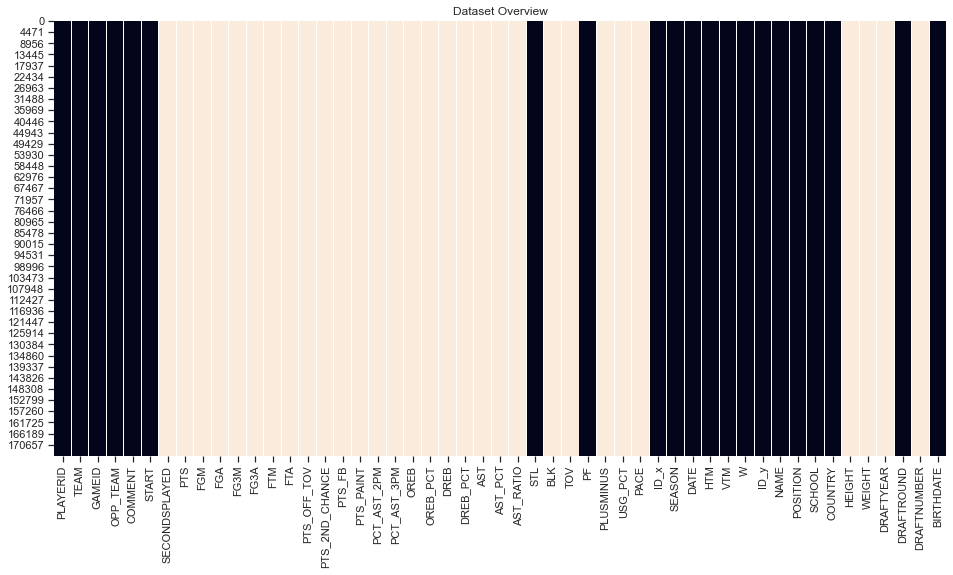

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [3]:
helpers = Helpers()

plt.rcParams["figure.figsize"] = (16, 8)
helpers.visualize_dataframe(boxscores)

Great, there is no missing data.

Next I will create the column of our dependant variable, $SP$.

In [4]:
y = 'Y'
boxscores[y] = boxscores['SECONDSPLAYED']

Let's take a look at the distribution of values of our dependant variable. I will use a histogram to to visualize the probability density distribution of the outcomes of $Y$, and a box plot to graph data groups and outliers.

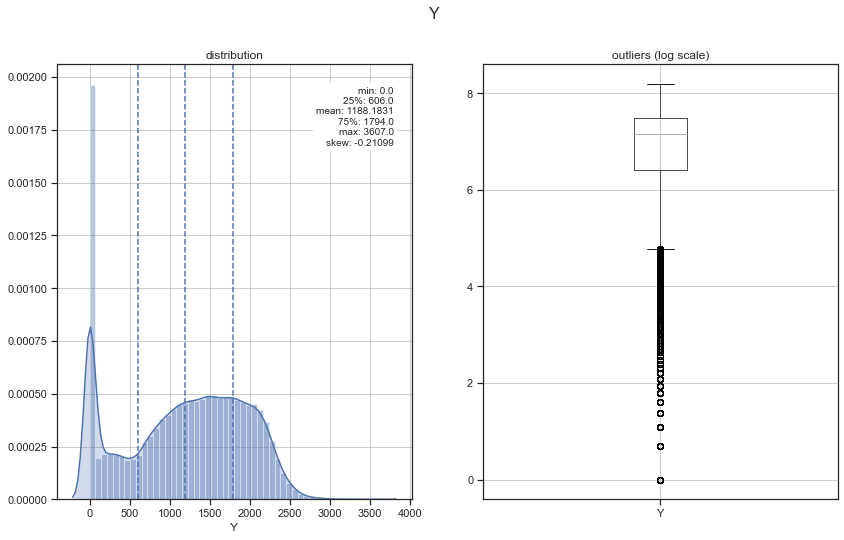

In [5]:
helpers.visualize_variable_distribution(boxscores, y, figsize=(14, 8))

Now let's visualize the distribution of $SP$ both in first 3 quarters, the 4th quarte, and in regulation.

In [6]:
q_boxscores = query_data.query_quarterly_boxscore_data()
q_boxscores = q_boxscores.pivot_table('SECONDSPLAYED', ['GAMEID', 'PLAYERID'], 'QUARTER')
q_boxscores.columns =['SP(Q{})'.format(str(col)) for col in q_boxscores.columns]

In [7]:
boxscores = boxscores.merge(q_boxscores, on=['GAMEID', 'PLAYERID'], how='left')
boxscores[q_boxscores.columns] = boxscores[q_boxscores.columns].fillna(0)

Q1-Q3:

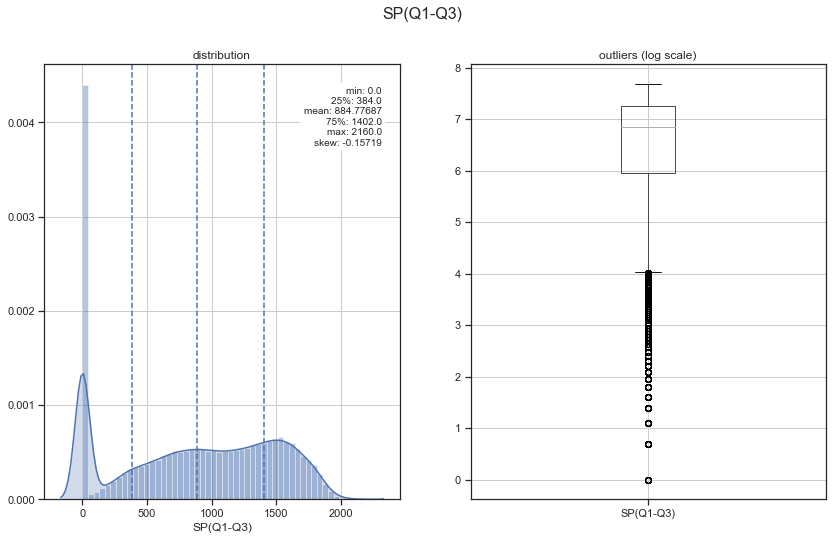

In [8]:
boxscores['SP(Q1-Q3)'] = boxscores['SP(Q1)'] + boxscores['SP(Q2)'] + boxscores['SP(Q3)']
helpers.visualize_variable_distribution(boxscores, 'SP(Q1-Q3)', figsize=(14, 8))

Q4:

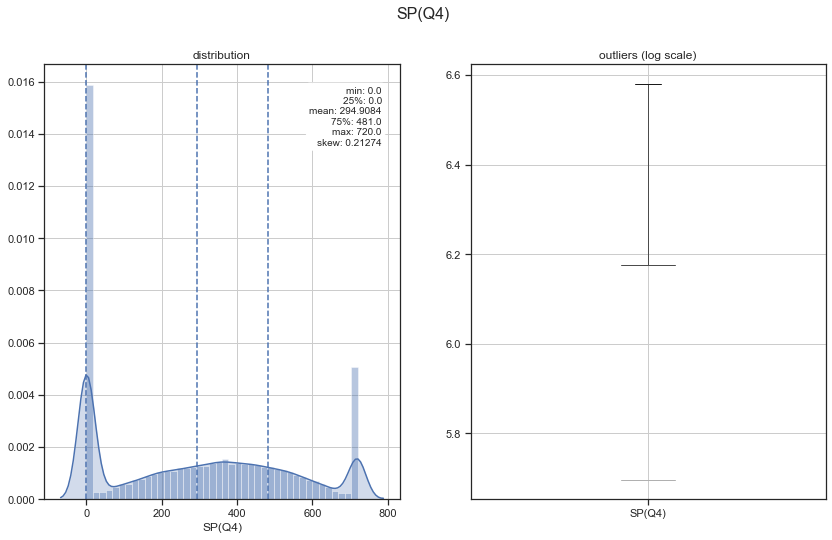

In [9]:
helpers.visualize_variable_distribution(boxscores, 'SP(Q4)', figsize=(14, 8))

Regulation:

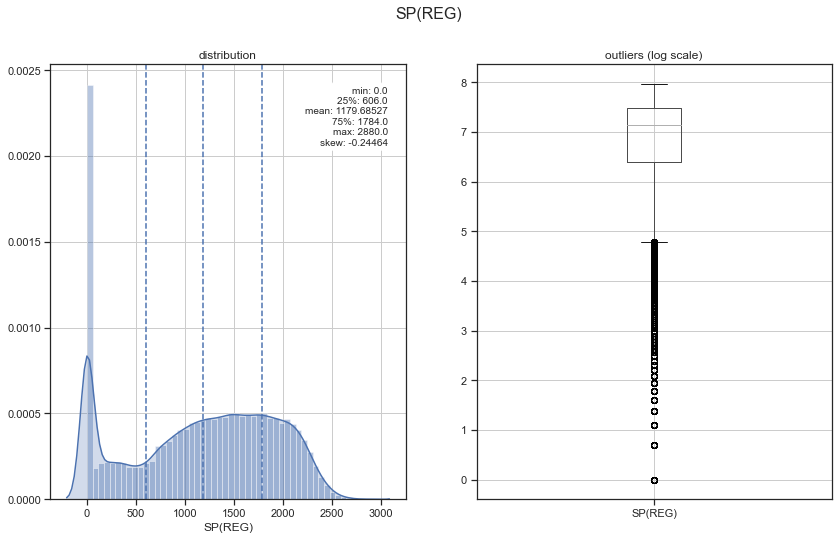

In [10]:
boxscores['SP(REG)'] = boxscores['SP(Q1-Q3)'] + boxscores['SP(Q4)']
helpers.visualize_variable_distribution(boxscores, 'SP(REG)', figsize=(14, 8))

# Feature Engineering
Create new features from raw data using domain knowlege.

In [11]:
regressors = []
categorical_regressors = []

### Historical PPS
First, I will create features based on a player's historical $SP$.

I will start by calculating the running $SP$ of a player in a season.

In [12]:
feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name='AVG_Y'
)

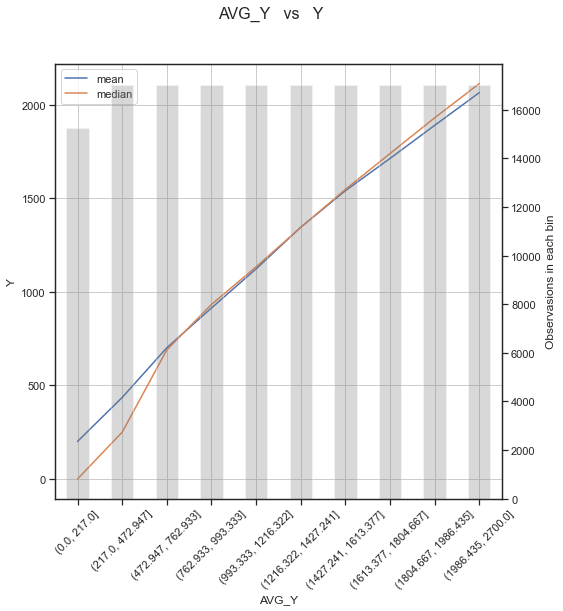

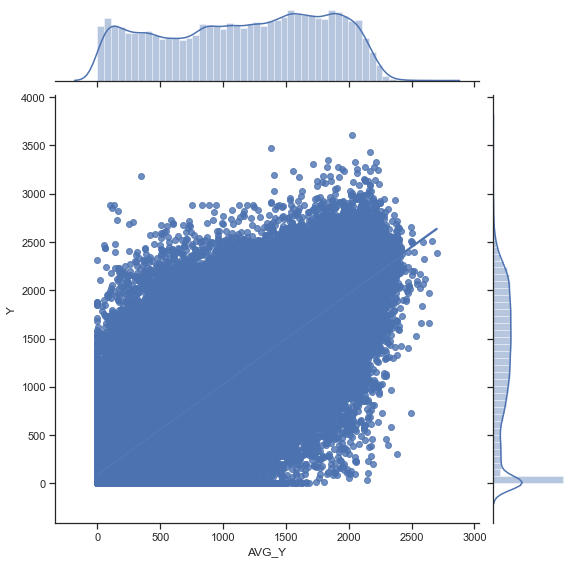

In [13]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_Y', y, figsize=(8, 8))

In [14]:
regressors.append('AVG_Y')

The average number of seconds played may be misleading, because it is affected by factors that do not necessarily apply to every game. For example, if a player played in overtime or in a blowout for a non-negligible proportion of his games that season, his AVG_$SP$ would be misleading.

To handle this, I will add 3 more features: the average seconds played in regulation (AVG_$SP(REG)$), the average seconds played in the first 3 quarters (AVG_$SP(Q1-Q3)$), and the average seconds played in the 4th quarter (AVG_$SP(Q4)$)

In [15]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(REG)', new_col_name='AVG_SP(REG)'
)
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(Q1-Q3)', new_col_name='AVG_SP(Q1-Q3)'
)
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(Q4)', new_col_name='AVG_SP(Q4)'
)

regressors.append('AVG_SP(REG)')
regressors.append('AVG_SP(Q1-Q3)')
regressors.append('AVG_SP(Q4)')

More recent $SP$ values matter more than less recent ones, on average. This is due to injuries, role changes, etc. To account for this, I will add the most recent $SP(REG)$, $SP(Q1-Q3)$, and $SP(Q4)$ performances, as well as an EWM of each stat.

In [16]:
boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(REG)', new_col_name='L1_SP(REG)', n_shift=1
)

boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(Q1-Q3)', new_col_name='L1_SP(Q1-Q3)', n_shift=1
)

boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(Q4)', new_col_name='L1_SP(Q4)', n_shift=1
)

regressors.append('L1_SP(REG)')
regressors.append('L1_SP(Q1-Q3)')
regressors.append('L1_SP(Q4)')


boxscores = feature_creation.expanding_ewm(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(REG)', new_col_name='EWM_SP(REG)', alpha=0.90
)
boxscores = feature_creation.expanding_ewm(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(Q1-Q3)', new_col_name='EWM_SP(Q1-Q3)', alpha=0.90
)
boxscores = feature_creation.expanding_ewm(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(Q4)', new_col_name='EWM_SP(Q4)', alpha=0.90
)

regressors.append('EWM_SP(REG)')
regressors.append('EWM_SP(Q1-Q3)')
regressors.append('EWM_SP(Q4)')

Next, I will calculate the partial correlation between each of $SP(REG)$, $SP(Q1-Q3)$, and $SP(Q4)$ and previous moving averages of each stat, using a covariate of the average of each stat. The peak of each graph will tell us which Moving Averages provides the most new information.

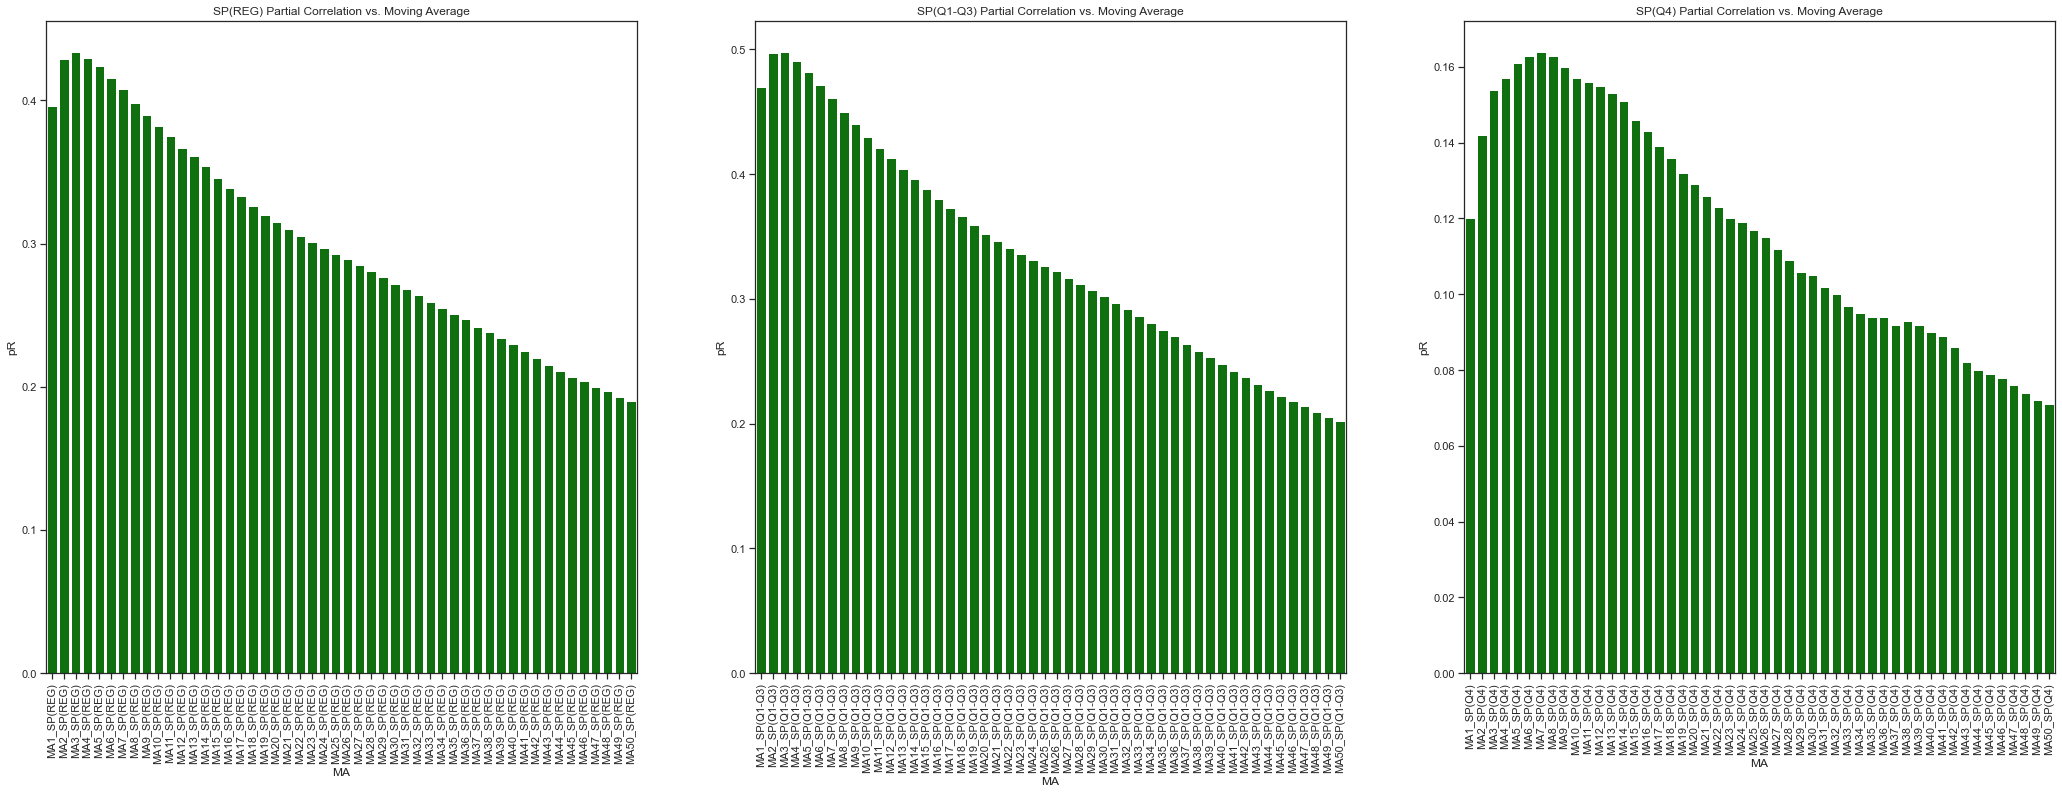

In [17]:
sp_reg_x_ticks = []
sp_reg_p_corrs = []

sp_q1to3_x_ticks = []
sp_q1to3_p_corrs = []

sp_q4_x_ticks = []
sp_q4_p_corrs = []
for i in range(1, 51):
    x = 'MA{}_SP(REG)'.format(str(i))

    boxscores = feature_creation.rolling_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(REG)', new_col_name=x,
        n_rolling=i, min_periods=math.ceil(i/2)
    )
    
    p_corr = pg.partial_corr(data=boxscores, x=x, y='SP(REG)', covar=['AVG_SP(REG)'])
    
    sp_reg_p_corrs.append(p_corr['r'][0])
    sp_reg_x_ticks.append(x)

    x = 'MA{}_SP(Q1-Q3)'.format(str(i))

    boxscores = feature_creation.rolling_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(Q1-Q3)', new_col_name=x,
        n_rolling=i, min_periods=math.ceil(i/2)
    )
    
    p_corr = pg.partial_corr(data=boxscores, x=x, y='SP(Q1-Q3)', covar=['AVG_SP(Q1-Q3)'])
    
    sp_q1to3_p_corrs.append(p_corr['r'][0])
    sp_q1to3_x_ticks.append(x)

    x = 'MA{}_SP(Q4)'.format(str(i))

    boxscores = feature_creation.rolling_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(Q4)', new_col_name=x,
        n_rolling=i, min_periods=math.ceil(i/2)
    )
    
    p_corr = pg.partial_corr(data=boxscores, x=x, y='SP(Q4)', covar=['AVG_SP(Q4)'])
    
    sp_q4_p_corrs.append(p_corr['r'][0])
    sp_q4_x_ticks.append(x)
    
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(36, 12))

sp_corr_df = pd.DataFrame({'pR': sp_reg_p_corrs, 'MA': sp_reg_x_ticks})

sns.barplot(x='MA', y='pR', data=sp_corr_df, color='green', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].title.set_text('SP(REG) Partial Correlation vs. Moving Average')

sp_q1to3_corr_df = pd.DataFrame({'pR': sp_q1to3_p_corrs, 'MA': sp_q1to3_x_ticks})

sns.barplot(x='MA', y='pR', data=sp_q1to3_corr_df, color='green', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].title.set_text('SP(Q1-Q3) Partial Correlation vs. Moving Average')

sp_q4_corr_df = pd.DataFrame({'pR': sp_q4_p_corrs, 'MA': sp_q4_x_ticks})

sns.barplot(x='MA', y='pR', data=sp_q4_corr_df, color='green', ax=ax[2])
ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=90)
ax[2].title.set_text('SP(Q4) Partial Correlation vs. Moving Average')

plt.show()
plt.close()

I will use MA2_$SP(REG)$, MA2_$SP(Q1-Q3)$, MA3_$SP(Q4)$, and MA7_$SP(Q4)$

In [18]:
regressors.append('MA2_SP(REG)')
regressors.append('MA2_SP(Q1-Q3)')
regressors.append('MA3_SP(Q4)')
regressors.append('MA7_SP(Q4)')

Now I will determine if the dependant variable, $Y$, depends on various categorical variables in our data set.

First I will determine if a player's $SP$ depends on his status as a Starter.

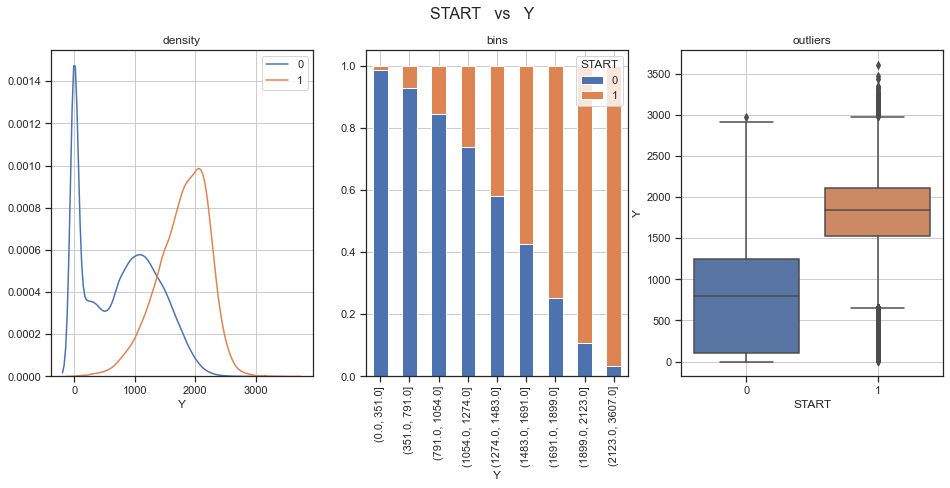

In [19]:
helpers.visualize_categorical_x_vs_y(boxscores, 'START', y)

There is a clear relationship between starting status and $SP$.

I will add a categorical variable that identifies if a player is starting, 'START', to the list of regressors. I will also add the season average $SP(REG)$ of a player in the role he is playing to our list of regressors. I will call this variable: $AVG\_SP(REG)\_R$.

In [20]:
regressors.append('START')
categorical_regressors.append('START')

boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name='SP(REG)', new_col_name='AVG_SP(REG)_R'
)
regressors.append('AVG_SP(REG)_R')

Next, I will determine if the number of days a player rests is indicative of his $SP$.

In [21]:
boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DATE', new_col_name='LAST_DATE'
)
boxscores['LAST_DATE'] = boxscores['LAST_DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)
boxscores['DATE'] = boxscores['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores['REST'] = boxscores[['DATE', 'LAST_DATE']].apply(
    lambda x: max(min((x[0] - x[1]).days, 5), 1) if not (isinstance(x[0], str) or isinstance(x[1], str)) else np.nan,
    axis=1
)

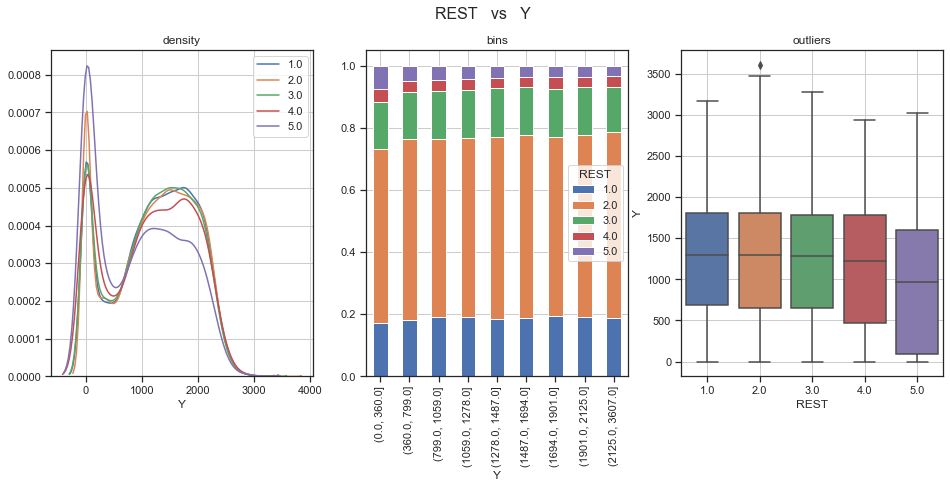

In [22]:
helpers.visualize_categorical_x_vs_y(boxscores, 'REST', y)

In [23]:
regressors.append('REST')

### Injuries
I will create features that quantify how injured the lineup is from a time played standpoint.

The first variable I will create to capture injuries is the depth of the lineup. This varaible will simply track the amount of active players playing.

In [24]:
temp = boxscores.groupby(['GAMEID', 'TEAM']).apply(
    lambda x: pd.Series({
        'DEPTH': x['PLAYERID'].count()
    })
)
boxscores = boxscores.merge(temp, on=['GAMEID', 'TEAM'], how='left')

regressors.append('DEPTH')

This variable explains the most about a player's time played in relation to the average depth of the lineup when the player played. I will add 2 more features: the average depth of the lineup for the games the player played in a season, and the the average depth of the lineup for the games the player played in his current role in a season.

In [25]:
boxscores = feature_creation.expanding_mean(df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='DEPTH', new_col_name='AVG_DEPTH')
boxscores = feature_creation.expanding_mean(df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name='DEPTH', new_col_name='AVG_DEPTH_R')

regressors.append('AVG_DEPTH')
regressors.append('AVG_DEPTH_R')

The current depth of the player's position may tell more than the depth of the entire lineup. To account for this, I will create analogous depth variables to the ones I created above.

In [26]:
boxscores['NORM_POS'] = boxscores['POSITION'].apply(lambda x: x if '-' not in x else x.split('-')[0])

temp = boxscores.groupby(['GAMEID', 'TEAM', 'NORM_POS']).apply(
    lambda x: pd.Series({
        'DEPTH_P': x['PLAYERID'].count()
    })
)
boxscores = boxscores.merge(temp, on=['GAMEID', 'TEAM', 'NORM_POS'], how='left')

boxscores = feature_creation.expanding_mean(df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='DEPTH_P', new_col_name='AVG_DEPTH_P')
boxscores = feature_creation.expanding_mean(df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name='DEPTH_P', new_col_name='AVG_DEPTH_P_R')

regressors.append('DEPTH_P')
regressors.append('AVG_DEPTH_P')
regressors.append('AVG_DEPTH_P_R')

The features describing the depth of the lineup don't take into account the quality of the players who are out, only the number of them. I will create a new feature that captures the sum of the average seconds played in regulation of all active players in the lineup. I will also create a feature that captures the average sum of the average seconds played in regulation, as a baseline.

In [27]:
temp = boxscores.dropna(subset=['AVG_SP(REG)'])
temp = temp.groupby(['GAMEID', 'TEAM']).apply(
    lambda x: pd.Series({
        'SUM_AVG_SP(REG)': x['AVG_SP(REG)'].sum()
    })
)

boxscores = boxscores.merge(temp, on=['GAMEID', 'TEAM'], how='left')
regressors.append('SUM_AVG_SP(REG)')

boxscores = feature_creation.expanding_mean(df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SUM_AVG_SP(REG)', new_col_name='AVG_SUM_AVG_SP(REG)')
boxscores = feature_creation.expanding_mean(df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name='SUM_AVG_SP(REG)', new_col_name='AVG_SUM_AVG_SP(REG)_R')

regressors.append('AVG_SUM_AVG_SP(REG)')
regressors.append('AVG_SUM_AVG_SP(REG)_R')

Again, I will create features analogous to the ones above, describing the average seconds played in regulation for all players by position.

In [28]:
temp = boxscores.dropna(subset=['AVG_SP(REG)'])
temp = temp.groupby(['GAMEID', 'TEAM', 'NORM_POS']).apply(
    lambda x: pd.Series({
        'SUM_AVG_SP(REG)_P': x['AVG_SP(REG)'].sum()
    })
)

boxscores = boxscores.merge(temp, on=['GAMEID', 'TEAM', 'NORM_POS'], how='left')
regressors.append('SUM_AVG_SP(REG)_P')

boxscores = feature_creation.expanding_mean(df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SUM_AVG_SP(REG)_P', new_col_name='AVG_SUM_AVG_SP(REG)_P')
boxscores = feature_creation.expanding_mean(df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name='SUM_AVG_SP(REG)_P', new_col_name='AVG_SUM_AVG_SP(REG)_P_R')

regressors.append('AVG_SUM_AVG_SP(REG)_P')
regressors.append('AVG_SUM_AVG_SP(REG)_P_R')

Not all players absorb lost time equally. To account for this, I will create a feature that tracks the $AVG\_SP(REG)$ of players when the starting lineup was the same. I will also create a feature that tracks the $AVG\_SP(REG)$ of players when the active star players on the team were the same (I will define 'star player' in this context as a player who averages over 2040 SP(REG) Per Game).

In [30]:
boxscores['START_LINEUP'] = np.nan
boxscores['STARS'] = np.nan
boxscores = boxscores.set_index(['GAMEID', 'TEAM'])
for (game_id, team), temp in boxscores.groupby(['GAMEID', 'TEAM']):
    start_lineup = list(temp.loc[temp['START'] == 1, 'PLAYERID'].values)
    start_lineup.sort()
    start_lineup = '_'.join(start_lineup)
    boxscores.loc[(game_id, team), 'START_LINEUP'] = start_lineup
    
    stars = list(temp.loc[temp['AVG_SP(REG)'] > 2040, 'PLAYERID'].values)
    stars.sort()
    stars = '_'.join(stars)
    boxscores.loc[(game_id, team), 'STARS'] = stars
boxscores = boxscores.reset_index()

boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'START_LINEUP', 'PLAYERID'], col_name='AVG_SP(REG)', new_col_name='AVG_SP(REG)_STARTERS'
)

boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'STARS', 'PLAYERID'], col_name='AVG_SP(REG)', new_col_name='AVG_SP(REG)_STARS'
)

regressors.append('AVG_SP(REG)_STARTERS')
regressors.append('AVG_SP(REG)_STARS')

### Blowout Risk
Next, I will create features that capture the blowout risk in a game.

In [31]:
odds = query_data.query_odds_data()
odds['POINTSPREAD'] = odds['POINTSPREAD'].replace(['PK', '-'], 0)
full_game_odds = odds.loc[odds['PERIOD'] == 'Full Game']

In [32]:
full_game_odds['DATE'] = full_game_odds['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores = boxscores.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')

The first feature I will create will be the absolute value of the vegas pointspread.

In [33]:
boxscores['ABS_POINTSPREAD'] = boxscores['POINTSPREAD'].abs()
regressors.append('ABS_POINTSPREAD')

Next, I will track the average point differential in games played by a player in the season (as a baseline).

In [34]:
temp = boxscores.groupby(['GAMEID', 'TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_PTS': x['PTS'].sum()
    })
)
boxscores = boxscores.merge(temp, on=['GAMEID', 'TEAM'], how='left')

temp = boxscores.groupby(['GAMEID', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'OPP_TEAM_PTS': x['PTS'].sum()
    })
)
boxscores = boxscores.merge(temp, left_on=['GAMEID', 'TEAM'], right_on=['GAMEID', 'OPP_TEAM'], how='left')

In [35]:
boxscores['DIFF_PTS'] = boxscores['TEAM_PTS'] - boxscores['OPP_TEAM_PTS']
boxscores['ABS_DIFF_PTS'] = boxscores['DIFF_PTS'].abs()

boxscores = feature_creation.expanding_mean(df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='ABS_DIFF_PTS', new_col_name='AVG_ABS_DIFF_PTS')
regressors.append('AVG_ABS_DIFF_PTS')

### Weights
TODO

In [36]:
w = 'WEIGHT'
boxscores[w] = 1

Some features we created to track historical performances mean less if the player has played less games.

In [37]:
boxscores['GP'] = 1
boxscores = feature_creation.expanding_sum(df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='GP', new_col_name='COUNT_GP')
regressors.append('COUNT_GP')

# Preprocessing
Now that I have created all the features I found to be indicative of our dependant variable, I will prepare the data to be suitable for a predictive model.

The first thing I will do is handle missing data.

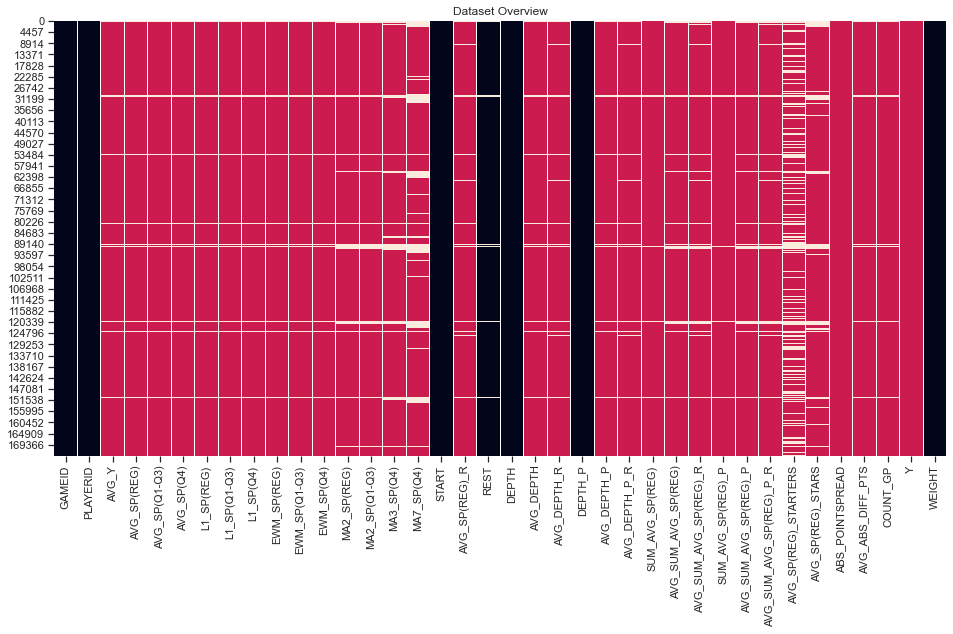

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 34.097


In [38]:
feature_matrix = boxscores[['GAMEID', 'PLAYERID'] + regressors + [y] + [w]]

helpers.visualize_dataframe(feature_matrix)

In [39]:
feature_matrix['L1_SP(REG)'] = feature_matrix['L1_SP(REG)'].fillna(feature_matrix['AVG_SP(REG)'])
feature_matrix['L1_SP(Q1-Q3)'] = feature_matrix['L1_SP(Q1-Q3)'].fillna(feature_matrix['AVG_SP(Q1-Q3)'])
feature_matrix['L1_SP(Q4)'] = feature_matrix['L1_SP(Q4)'].fillna(feature_matrix['AVG_SP(Q4)'])

feature_matrix['EWM_SP(REG)'] = feature_matrix['EWM_SP(REG)'].fillna(feature_matrix['AVG_SP(REG)'])
feature_matrix['EWM_SP(Q1-Q3)'] = feature_matrix['EWM_SP(Q1-Q3)'].fillna(feature_matrix['AVG_SP(Q1-Q3)'])
feature_matrix['EWM_SP(Q4)'] = feature_matrix['EWM_SP(Q4)'].fillna(feature_matrix['AVG_SP(Q4)'])

feature_matrix['MA2_SP(REG)'] = feature_matrix['MA2_SP(REG)'].fillna(feature_matrix['AVG_SP(REG)'])
feature_matrix['MA2_SP(Q1-Q3)'] = feature_matrix['MA2_SP(Q1-Q3)'].fillna(feature_matrix['AVG_SP(Q1-Q3)'])
feature_matrix['MA3_SP(Q4)'] = feature_matrix['MA3_SP(Q4)'].fillna(feature_matrix['AVG_SP(Q4)'])
feature_matrix['MA7_SP(Q4)'] = feature_matrix['MA7_SP(Q4)'].fillna(feature_matrix['MA3_SP(Q4)'])

feature_matrix['AVG_SP(REG)_R'] = feature_matrix['AVG_SP(REG)_R'].fillna(feature_matrix['AVG_SP(REG)'])

feature_matrix['AVG_DEPTH_R'] = feature_matrix['AVG_DEPTH_R'].fillna(feature_matrix['AVG_DEPTH'])
feature_matrix['AVG_DEPTH_P_R'] = feature_matrix['AVG_DEPTH_P_R'].fillna(feature_matrix['AVG_DEPTH_P'])

feature_matrix['AVG_SUM_AVG_SP(REG)'] = feature_matrix['AVG_SUM_AVG_SP(REG)'].fillna(feature_matrix['SUM_AVG_SP(REG)'])
feature_matrix['AVG_SUM_AVG_SP(REG)_R'] = feature_matrix['AVG_SUM_AVG_SP(REG)_R'].fillna(feature_matrix['AVG_SUM_AVG_SP(REG)'])
feature_matrix['AVG_SUM_AVG_SP(REG)_P'] = feature_matrix['AVG_SUM_AVG_SP(REG)_P'].fillna(feature_matrix['SUM_AVG_SP(REG)_P'])
feature_matrix['AVG_SUM_AVG_SP(REG)_P_R'] = feature_matrix['AVG_SUM_AVG_SP(REG)_P_R'].fillna(feature_matrix['AVG_SUM_AVG_SP(REG)_P'])

feature_matrix['AVG_SP(REG)_STARS'] = feature_matrix['AVG_SP(REG)_STARS'].fillna(feature_matrix['AVG_SP(REG)'])
feature_matrix['AVG_SP(REG)_STARTERS'] = feature_matrix['AVG_SP(REG)_STARTERS'].fillna(feature_matrix['AVG_SP(REG)_STARS'])

feature_matrix['COUNT_GP'] = feature_matrix['COUNT_GP'].fillna(0)

feature_matrix['ABS_POINTSPREAD'] = feature_matrix['ABS_POINTSPREAD'].fillna(0)
feature_matrix['AVG_ABS_DIFF_PTS'] = feature_matrix['AVG_ABS_DIFF_PTS'].fillna(feature_matrix['ABS_POINTSPREAD'])

# we can predict Y for a player as long as AVG_Y is not nan
feature_matrix = feature_matrix.dropna(subset=['AVG_Y'])

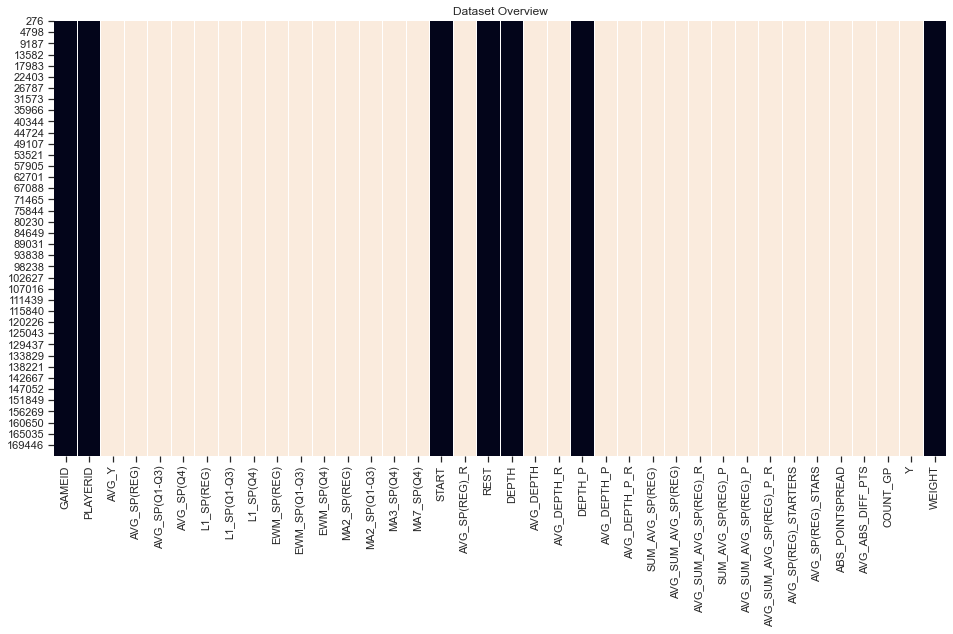

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [40]:
helpers.visualize_dataframe(feature_matrix)

# Model/Feature Selection
Finally, it's time to build the model. I will first iterate through various model types. Within each model iteration, I will isolate the important features. I will also try predicting the log transform of the dependant variable, and scaling the numeric columns, and pick whatever (Model, Feature Subset, \[Log Transform, No Transform\], \[Scale, No Scale\]) combination yeilds the lowest average MSE after 5-fold cross validation.

In [41]:
linear_models = [
    linear_model.LinearRegression(),
#     linear_model.Ridge(),
#     linear_model.ElasticNet()
]

neighbor_models = [
#     neighbors.KNeighborsRegressor()
]

boosted_models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

neural_networks = [
    neural_network.MLPRegressor(max_iter=10000, early_stopping=True, random_state=42)
]

models = linear_models + neighbor_models + boosted_models + neural_networks

transformers = [
    {
        'Function': lambda x: x,
        'Inverse Function': lambda x: x,
        'Name': 'None'
    }
]

numeric_regressors = list(set(regressors) - set(categorical_regressors))
numeric_columns = numeric_regressors + [y]

min_score = float('inf')
best_model = None
for model in models:
    for transformer in transformers:
        for scale in [False, True]:
            
            # transform numeric columns
            feature_matrix_t = feature_matrix.copy()
            feature_matrix_t[numeric_columns] = feature_matrix_t[numeric_columns].apply(
                transformer['Function'], axis=1
            )
            
            # scale numeric features
            if scale:
                x_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                feature_matrix_t[numeric_regressors] = x_scaler.fit_transform(feature_matrix_t[numeric_regressors])
                
                y_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                feature_matrix_t[[y]] = y_scaler.fit_transform(feature_matrix_t[[y]])

            # feature selection
            X = feature_matrix_t[regressors]
            Y = feature_matrix_t[y]
            W = feature_matrix_t[w]

            if model in (neighbor_models + neural_networks):
                selected_features = regressors.copy()
            else:
                model.fit(X, Y, sample_weight=W)
                
                # importance
                importance_selector = SelectFromModel(model, threshold='0.75*median')
                importance_selector = importance_selector.fit(X, Y, sample_weight=W)
                importance_support = importance_selector.get_support()
                
                # rank
                rank_selector = RFE(model)
                rank_selector = rank_selector.fit(X, Y)
                rank_support = rank_selector.ranking_
                median_rank = np.median(rank_support)
                
                selected_features = []
                for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
                    # select the feature if it's important, or has a low rank
                    if importance_flag or (rank <= median_rank):
                        selected_features.append(feature)
            
            X = feature_matrix_t[selected_features].values
            Y = feature_matrix_t[y].values
            W = feature_matrix_t[w].values
            
            # cross validation
            scores = []
            cv = model_selection.KFold(n_splits=5, shuffle=True)
            for train, test in cv.split(X, Y, W):
                if model in (neural_networks + neighbor_models):
                    prediction = model.fit(X[train], Y[train]).predict(X[test])
                else:
                    prediction = model.fit(X[train], Y[train], sample_weight=W[train]).predict(X[test])
                true = Y[test]

                if scale:
                    prediction = y_scaler.inverse_transform(prediction.reshape(-1,1)).reshape(-1)
                    true = y_scaler.inverse_transform(true.reshape(-1,1)).reshape(-1)

                prediction = transformer['Inverse Function'](prediction)
                true = transformer['Inverse Function'](true)
                
                scores.append(metrics.mean_absolute_error(prediction, true, sample_weight=W[test]))

            mean_score = np.mean(scores)
            print('Model:', model)
            print('Transformer:', transformer['Name'])
            print('Scale:', scale)
            print('Selected Features:', selected_features)
            print('Mean MAE:', mean_score)
            print()
            if mean_score < min_score:
                min_score = mean_score
                best_model = (model, transformer['Name'], scale, selected_features)
print(best_model, min_score)

Model: LinearRegression()
Transformer: None
Scale: False
Selected Features: ['L1_SP(REG)', 'L1_SP(Q1-Q3)', 'L1_SP(Q4)', 'EWM_SP(REG)', 'EWM_SP(Q1-Q3)', 'EWM_SP(Q4)', 'MA2_SP(REG)', 'MA2_SP(Q1-Q3)', 'MA7_SP(Q4)', 'START', 'AVG_SP(REG)_R', 'REST', 'DEPTH', 'AVG_DEPTH', 'AVG_DEPTH_R', 'DEPTH_P', 'AVG_DEPTH_P', 'AVG_DEPTH_P_R', 'AVG_ABS_DIFF_PTS']
Mean MAE: 286.0970810423655

Model: LinearRegression()
Transformer: None
Scale: True
Selected Features: ['AVG_Y', 'AVG_SP(REG)', 'AVG_SP(Q1-Q3)', 'L1_SP(REG)', 'L1_SP(Q1-Q3)', 'L1_SP(Q4)', 'EWM_SP(REG)', 'EWM_SP(Q1-Q3)', 'EWM_SP(Q4)', 'MA2_SP(REG)', 'MA2_SP(Q1-Q3)', 'MA7_SP(Q4)', 'START', 'AVG_SP(REG)_R', 'SUM_AVG_SP(REG)', 'SUM_AVG_SP(REG)_P', 'AVG_SUM_AVG_SP(REG)_P', 'AVG_SP(REG)_STARS']
Mean MAE: 283.77834315073204

Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',

The best model is a Catboost model with no log transformations or scaling.

# Parameter Tuning
Now, I will use Grid Search Cross Validation to find the CatBoostRegressor paramters that yeild the lowest average MSE on the test set.

In [52]:
selected_features = ['AVG_Y', 'AVG_SP(REG)', 'AVG_SP(Q1-Q3)', 'AVG_SP(Q4)', 'L1_SP(REG)', 'L1_SP(Q1-Q3)',
                     'EWM_SP(REG)', 'EWM_SP(Q1-Q3)', 'MA2_SP(REG)', 'MA2_SP(Q1-Q3)', 'MA7_SP(Q4)',
                     'START', 'AVG_SP(REG)_R', 'DEPTH', 'SUM_AVG_SP(REG)', 'AVG_SUM_AVG_SP(REG)',
                     'AVG_SUM_AVG_SP(REG)_R', 'SUM_AVG_SP(REG)_P', 'AVG_SUM_AVG_SP(REG)_P',
                     'AVG_SP(REG)_STARTERS', 'AVG_SP(REG)_STARS', 'ABS_POINTSPREAD', 'AVG_ABS_DIFF_PTS', 'COUNT_GP']
# selected_features = best_model[3]
X = feature_matrix[selected_features]
Y = feature_matrix[y]
W = feature_matrix[w]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.25, random_state=1)

In [53]:
model = CatBoostRegressor()

model_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'num_boost_round': [5000],
    'eval_metric': ['MAE']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": (X_test, y_test),
    'sample_weight': w_train
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

0:	learn: 622.1916983	test: 622.9251597	best: 622.9251597 (0)	total: 59ms	remaining: 4m 55s
1:	learn: 617.6000303	test: 618.3664987	best: 618.3664987 (1)	total: 79.4ms	remaining: 3m 18s
2:	learn: 613.0594110	test: 613.8391936	best: 613.8391936 (2)	total: 135ms	remaining: 3m 45s
3:	learn: 608.5171178	test: 609.3066100	best: 609.3066100 (3)	total: 190ms	remaining: 3m 57s
4:	learn: 604.0388254	test: 604.8558303	best: 604.8558303 (4)	total: 241ms	remaining: 4m
5:	learn: 599.6109815	test: 600.4492395	best: 600.4492395 (5)	total: 301ms	remaining: 4m 10s
6:	learn: 595.2390815	test: 596.1061300	best: 596.1061300 (6)	total: 362ms	remaining: 4m 17s
7:	learn: 590.9332593	test: 591.8232010	best: 591.8232010 (7)	total: 414ms	remaining: 4m 18s
8:	learn: 586.6708882	test: 587.5899039	best: 587.5899039 (8)	total: 474ms	remaining: 4m 22s
9:	learn: 582.4942350	test: 583.4459728	best: 583.4459728 (9)	total: 532ms	remaining: 4m 25s
10:	learn: 578.3743523	test: 579.3587818	best: 579.3587818 (10)	total: 585

89:	learn: 378.2142794	test: 380.8636162	best: 380.8636162 (89)	total: 5.94s	remaining: 5m 23s
90:	learn: 376.8350342	test: 379.5016383	best: 379.5016383 (90)	total: 6s	remaining: 5m 23s
91:	learn: 375.4796494	test: 378.1495440	best: 378.1495440 (91)	total: 6.06s	remaining: 5m 23s
92:	learn: 374.1217573	test: 376.7931770	best: 376.7931770 (92)	total: 6.13s	remaining: 5m 23s
93:	learn: 372.7960107	test: 375.4798861	best: 375.4798861 (93)	total: 6.2s	remaining: 5m 23s
94:	learn: 371.4793444	test: 374.1732249	best: 374.1732249 (94)	total: 6.27s	remaining: 5m 23s
95:	learn: 370.1741637	test: 372.8757760	best: 372.8757760 (95)	total: 6.34s	remaining: 5m 23s
96:	learn: 368.9160491	test: 371.6208763	best: 371.6208763 (96)	total: 6.4s	remaining: 5m 23s
97:	learn: 367.6827511	test: 370.3920443	best: 370.3920443 (97)	total: 6.47s	remaining: 5m 23s
98:	learn: 366.4607385	test: 369.1708459	best: 369.1708459 (98)	total: 6.53s	remaining: 5m 23s
99:	learn: 365.2404321	test: 367.9564937	best: 367.9564

174:	learn: 308.7899452	test: 311.9021859	best: 311.9021859 (174)	total: 11.4s	remaining: 5m 14s
175:	learn: 308.3604281	test: 311.4746966	best: 311.4746966 (175)	total: 11.5s	remaining: 5m 14s
176:	learn: 307.9442123	test: 311.0599367	best: 311.0599367 (176)	total: 11.5s	remaining: 5m 13s
177:	learn: 307.5280205	test: 310.6499048	best: 310.6499048 (177)	total: 11.6s	remaining: 5m 13s
178:	learn: 307.1260599	test: 310.2506542	best: 310.2506542 (178)	total: 11.6s	remaining: 5m 13s
179:	learn: 306.7295581	test: 309.8561317	best: 309.8561317 (179)	total: 11.7s	remaining: 5m 12s
180:	learn: 306.3231856	test: 309.4521501	best: 309.4521501 (180)	total: 11.7s	remaining: 5m 12s
181:	learn: 305.9271551	test: 309.0609594	best: 309.0609594 (181)	total: 11.8s	remaining: 5m 11s
182:	learn: 305.5311071	test: 308.6702665	best: 308.6702665 (182)	total: 11.9s	remaining: 5m 11s
183:	learn: 305.1604011	test: 308.3002373	best: 308.3002373 (183)	total: 11.9s	remaining: 5m 11s
184:	learn: 304.7827386	test: 

261:	learn: 286.1664747	test: 289.6596310	best: 289.6596310 (261)	total: 16.1s	remaining: 4m 51s
262:	learn: 286.0284243	test: 289.5226321	best: 289.5226321 (262)	total: 16.2s	remaining: 4m 51s
263:	learn: 285.8866611	test: 289.3818309	best: 289.3818309 (263)	total: 16.3s	remaining: 4m 51s
264:	learn: 285.7423487	test: 289.2436994	best: 289.2436994 (264)	total: 16.3s	remaining: 4m 51s
265:	learn: 285.5996610	test: 289.1038783	best: 289.1038783 (265)	total: 16.4s	remaining: 4m 51s
266:	learn: 285.4573208	test: 288.9649585	best: 288.9649585 (266)	total: 16.4s	remaining: 4m 51s
267:	learn: 285.3187656	test: 288.8283423	best: 288.8283423 (267)	total: 16.5s	remaining: 4m 51s
268:	learn: 285.1743334	test: 288.6934706	best: 288.6934706 (268)	total: 16.5s	remaining: 4m 50s
269:	learn: 285.0345797	test: 288.5582105	best: 288.5582105 (269)	total: 16.6s	remaining: 4m 50s
270:	learn: 284.8991264	test: 288.4287056	best: 288.4287056 (270)	total: 16.6s	remaining: 4m 50s
271:	learn: 284.7674794	test: 

346:	learn: 277.8235414	test: 281.7466943	best: 281.7466943 (346)	total: 20.7s	remaining: 4m 37s
347:	learn: 277.7598282	test: 281.6867207	best: 281.6867207 (347)	total: 20.7s	remaining: 4m 37s
348:	learn: 277.6981858	test: 281.6292803	best: 281.6292803 (348)	total: 20.8s	remaining: 4m 36s
349:	learn: 277.6382773	test: 281.5757676	best: 281.5757676 (349)	total: 20.8s	remaining: 4m 36s
350:	learn: 277.5805533	test: 281.5246411	best: 281.5246411 (350)	total: 20.9s	remaining: 4m 36s
351:	learn: 277.5223385	test: 281.4711842	best: 281.4711842 (351)	total: 20.9s	remaining: 4m 36s
352:	learn: 277.4599234	test: 281.4107682	best: 281.4107682 (352)	total: 21s	remaining: 4m 36s
353:	learn: 277.3949028	test: 281.3526235	best: 281.3526235 (353)	total: 21s	remaining: 4m 36s
354:	learn: 277.3368158	test: 281.2987427	best: 281.2987427 (354)	total: 21.1s	remaining: 4m 36s
355:	learn: 277.2699923	test: 281.2383797	best: 281.2383797 (355)	total: 21.2s	remaining: 4m 35s
356:	learn: 277.2056864	test: 281.

431:	learn: 273.8361690	test: 278.2510332	best: 278.2510332 (431)	total: 26.2s	remaining: 4m 37s
432:	learn: 273.8030077	test: 278.2232480	best: 278.2232480 (432)	total: 26.3s	remaining: 4m 37s
433:	learn: 273.7693005	test: 278.1932848	best: 278.1932848 (433)	total: 26.4s	remaining: 4m 37s
434:	learn: 273.7354044	test: 278.1676705	best: 278.1676705 (434)	total: 26.5s	remaining: 4m 37s
435:	learn: 273.7049194	test: 278.1447723	best: 278.1447723 (435)	total: 26.5s	remaining: 4m 37s
436:	learn: 273.6662715	test: 278.1144981	best: 278.1144981 (436)	total: 26.6s	remaining: 4m 37s
437:	learn: 273.6325909	test: 278.0873486	best: 278.0873486 (437)	total: 26.7s	remaining: 4m 37s
438:	learn: 273.6017788	test: 278.0629312	best: 278.0629312 (438)	total: 26.7s	remaining: 4m 37s
439:	learn: 273.5681712	test: 278.0355971	best: 278.0355971 (439)	total: 26.8s	remaining: 4m 37s
440:	learn: 273.5352724	test: 278.0097450	best: 278.0097450 (440)	total: 26.9s	remaining: 4m 37s
441:	learn: 273.5054029	test: 

519:	learn: 271.5322566	test: 276.4791251	best: 276.4791251 (519)	total: 32.2s	remaining: 4m 37s
520:	learn: 271.5160425	test: 276.4642926	best: 276.4642926 (520)	total: 32.3s	remaining: 4m 37s
521:	learn: 271.4950694	test: 276.4517321	best: 276.4517321 (521)	total: 32.3s	remaining: 4m 37s
522:	learn: 271.4771554	test: 276.4381068	best: 276.4381068 (522)	total: 32.4s	remaining: 4m 37s
523:	learn: 271.4604537	test: 276.4280828	best: 276.4280828 (523)	total: 32.5s	remaining: 4m 37s
524:	learn: 271.4429611	test: 276.4131995	best: 276.4131995 (524)	total: 32.5s	remaining: 4m 37s
525:	learn: 271.4201231	test: 276.3999427	best: 276.3999427 (525)	total: 32.6s	remaining: 4m 37s
526:	learn: 271.4045768	test: 276.3892861	best: 276.3892861 (526)	total: 32.6s	remaining: 4m 36s
527:	learn: 271.3843112	test: 276.3760716	best: 276.3760716 (527)	total: 32.7s	remaining: 4m 36s
528:	learn: 271.3643268	test: 276.3607108	best: 276.3607108 (528)	total: 32.7s	remaining: 4m 36s
529:	learn: 271.3469164	test: 

605:	learn: 270.0715683	test: 275.5242126	best: 275.5242126 (605)	total: 37.5s	remaining: 4m 31s
606:	learn: 270.0553202	test: 275.5120451	best: 275.5120451 (606)	total: 37.5s	remaining: 4m 31s
607:	learn: 270.0414558	test: 275.5033492	best: 275.5033492 (607)	total: 37.6s	remaining: 4m 31s
608:	learn: 270.0271513	test: 275.4978914	best: 275.4978914 (608)	total: 37.6s	remaining: 4m 31s
609:	learn: 270.0119601	test: 275.4912361	best: 275.4912361 (609)	total: 37.7s	remaining: 4m 31s
610:	learn: 269.9960244	test: 275.4841616	best: 275.4841616 (610)	total: 37.7s	remaining: 4m 31s
611:	learn: 269.9823595	test: 275.4745673	best: 275.4745673 (611)	total: 37.8s	remaining: 4m 31s
612:	learn: 269.9667409	test: 275.4665577	best: 275.4665577 (612)	total: 37.9s	remaining: 4m 30s
613:	learn: 269.9544399	test: 275.4593735	best: 275.4593735 (613)	total: 37.9s	remaining: 4m 30s
614:	learn: 269.9421892	test: 275.4547349	best: 275.4547349 (614)	total: 38s	remaining: 4m 30s
615:	learn: 269.9247763	test: 27

693:	learn: 268.9103953	test: 274.9254716	best: 274.9254716 (693)	total: 42.2s	remaining: 4m 21s
694:	learn: 268.8990110	test: 274.9212852	best: 274.9212852 (694)	total: 42.3s	remaining: 4m 21s
695:	learn: 268.8903872	test: 274.9170091	best: 274.9170091 (695)	total: 42.3s	remaining: 4m 21s
696:	learn: 268.8787710	test: 274.9103658	best: 274.9103658 (696)	total: 42.4s	remaining: 4m 21s
697:	learn: 268.8659544	test: 274.9032729	best: 274.9032729 (697)	total: 42.4s	remaining: 4m 21s
698:	learn: 268.8497219	test: 274.8961880	best: 274.8961880 (698)	total: 42.5s	remaining: 4m 21s
699:	learn: 268.8433928	test: 274.8929142	best: 274.8929142 (699)	total: 42.5s	remaining: 4m 21s
700:	learn: 268.8280790	test: 274.8869937	best: 274.8869937 (700)	total: 42.6s	remaining: 4m 21s
701:	learn: 268.8180175	test: 274.8827004	best: 274.8827004 (701)	total: 42.7s	remaining: 4m 21s
702:	learn: 268.8063619	test: 274.8781414	best: 274.8781414 (702)	total: 42.7s	remaining: 4m 21s
703:	learn: 268.7952064	test: 

780:	learn: 267.9502932	test: 274.5131634	best: 274.5131634 (780)	total: 47s	remaining: 4m 13s
781:	learn: 267.9406018	test: 274.5059846	best: 274.5059846 (781)	total: 47s	remaining: 4m 13s
782:	learn: 267.9312363	test: 274.5023127	best: 274.5023127 (782)	total: 47.1s	remaining: 4m 13s
783:	learn: 267.9209924	test: 274.4974370	best: 274.4974370 (783)	total: 47.1s	remaining: 4m 13s
784:	learn: 267.9089589	test: 274.4907328	best: 274.4907328 (784)	total: 47.2s	remaining: 4m 13s
785:	learn: 267.8987371	test: 274.4866978	best: 274.4866978 (785)	total: 47.2s	remaining: 4m 13s
786:	learn: 267.8899100	test: 274.4835224	best: 274.4835224 (786)	total: 47.3s	remaining: 4m 13s
787:	learn: 267.8806992	test: 274.4808909	best: 274.4808909 (787)	total: 47.3s	remaining: 4m 13s
788:	learn: 267.8713224	test: 274.4788736	best: 274.4788736 (788)	total: 47.4s	remaining: 4m 12s
789:	learn: 267.8624019	test: 274.4729137	best: 274.4729137 (789)	total: 47.5s	remaining: 4m 12s
790:	learn: 267.8541912	test: 274.

868:	learn: 267.0996987	test: 274.2084474	best: 274.2084474 (868)	total: 51.6s	remaining: 4m 5s
869:	learn: 267.0882093	test: 274.2055275	best: 274.2055275 (869)	total: 51.6s	remaining: 4m 5s
870:	learn: 267.0790720	test: 274.2010930	best: 274.2010930 (870)	total: 51.7s	remaining: 4m 4s
871:	learn: 267.0687397	test: 274.1962006	best: 274.1962006 (871)	total: 51.7s	remaining: 4m 4s
872:	learn: 267.0587166	test: 274.1938329	best: 274.1938329 (872)	total: 51.8s	remaining: 4m 4s
873:	learn: 267.0470776	test: 274.1913426	best: 274.1913426 (873)	total: 51.8s	remaining: 4m 4s
874:	learn: 267.0346980	test: 274.1884531	best: 274.1884531 (874)	total: 51.9s	remaining: 4m 4s
875:	learn: 267.0278705	test: 274.1857540	best: 274.1857540 (875)	total: 51.9s	remaining: 4m 4s
876:	learn: 267.0201462	test: 274.1822391	best: 274.1822391 (876)	total: 52s	remaining: 4m 4s
877:	learn: 267.0097878	test: 274.1803147	best: 274.1803147 (877)	total: 52s	remaining: 4m 4s
878:	learn: 267.0045177	test: 274.1772738	be

955:	learn: 266.2199749	test: 273.9301277	best: 273.9301277 (955)	total: 57.4s	remaining: 4m 2s
956:	learn: 266.2120532	test: 273.9286759	best: 273.9286759 (956)	total: 57.4s	remaining: 4m 2s
957:	learn: 266.2036522	test: 273.9251633	best: 273.9251633 (957)	total: 57.5s	remaining: 4m 2s
958:	learn: 266.1946435	test: 273.9254178	best: 273.9251633 (957)	total: 57.6s	remaining: 4m 2s
959:	learn: 266.1870380	test: 273.9226317	best: 273.9226317 (959)	total: 57.7s	remaining: 4m 2s
960:	learn: 266.1807278	test: 273.9209106	best: 273.9209106 (960)	total: 57.7s	remaining: 4m 2s
961:	learn: 266.1678009	test: 273.9180208	best: 273.9180208 (961)	total: 57.8s	remaining: 4m 2s
962:	learn: 266.1582321	test: 273.9141077	best: 273.9141077 (962)	total: 57.9s	remaining: 4m 2s
963:	learn: 266.1524245	test: 273.9111961	best: 273.9111961 (963)	total: 58s	remaining: 4m 2s
964:	learn: 266.1426994	test: 273.9092209	best: 273.9092209 (964)	total: 58.1s	remaining: 4m 2s
965:	learn: 266.1297799	test: 273.9039197	

1041:	learn: 265.4211086	test: 273.7187202	best: 273.7187202 (1041)	total: 1m 3s	remaining: 4m
1042:	learn: 265.4047643	test: 273.7133370	best: 273.7133370 (1042)	total: 1m 3s	remaining: 4m
1043:	learn: 265.3991988	test: 273.7120778	best: 273.7120778 (1043)	total: 1m 3s	remaining: 4m
1044:	learn: 265.3914520	test: 273.7094239	best: 273.7094239 (1044)	total: 1m 3s	remaining: 3m 59s
1045:	learn: 265.3842737	test: 273.7085941	best: 273.7085941 (1045)	total: 1m 3s	remaining: 3m 59s
1046:	learn: 265.3742406	test: 273.7057597	best: 273.7057597 (1046)	total: 1m 3s	remaining: 3m 59s
1047:	learn: 265.3672335	test: 273.7037106	best: 273.7037106 (1047)	total: 1m 3s	remaining: 3m 59s
1048:	learn: 265.3549966	test: 273.7003232	best: 273.7003232 (1048)	total: 1m 3s	remaining: 3m 59s
1049:	learn: 265.3408023	test: 273.6954219	best: 273.6954219 (1049)	total: 1m 3s	remaining: 3m 59s
1050:	learn: 265.3317843	test: 273.6911823	best: 273.6911823 (1050)	total: 1m 3s	remaining: 3m 59s
1051:	learn: 265.32482

1127:	learn: 264.6267309	test: 273.5231651	best: 273.5228321 (1126)	total: 1m 8s	remaining: 3m 55s
1128:	learn: 264.6211375	test: 273.5212317	best: 273.5212317 (1128)	total: 1m 8s	remaining: 3m 55s
1129:	learn: 264.6176867	test: 273.5198054	best: 273.5198054 (1129)	total: 1m 8s	remaining: 3m 55s
1130:	learn: 264.6109547	test: 273.5185405	best: 273.5185405 (1130)	total: 1m 8s	remaining: 3m 55s
1131:	learn: 264.6017021	test: 273.5176988	best: 273.5176988 (1131)	total: 1m 8s	remaining: 3m 55s
1132:	learn: 264.5943107	test: 273.5148393	best: 273.5148393 (1132)	total: 1m 8s	remaining: 3m 54s
1133:	learn: 264.5849543	test: 273.5117495	best: 273.5117495 (1133)	total: 1m 8s	remaining: 3m 54s
1134:	learn: 264.5771361	test: 273.5071475	best: 273.5071475 (1134)	total: 1m 8s	remaining: 3m 54s
1135:	learn: 264.5679013	test: 273.5047613	best: 273.5047613 (1135)	total: 1m 9s	remaining: 3m 54s
1136:	learn: 264.5631823	test: 273.5045352	best: 273.5045352 (1136)	total: 1m 9s	remaining: 3m 54s
1137:	lear

1211:	learn: 263.8834540	test: 273.3559380	best: 273.3559380 (1211)	total: 1m 13s	remaining: 3m 48s
1212:	learn: 263.8719914	test: 273.3522991	best: 273.3522991 (1212)	total: 1m 13s	remaining: 3m 48s
1213:	learn: 263.8612693	test: 273.3494341	best: 273.3494341 (1213)	total: 1m 13s	remaining: 3m 48s
1214:	learn: 263.8547662	test: 273.3475646	best: 273.3475646 (1214)	total: 1m 13s	remaining: 3m 48s
1215:	learn: 263.8469433	test: 273.3467586	best: 273.3467586 (1215)	total: 1m 13s	remaining: 3m 48s
1216:	learn: 263.8381479	test: 273.3446178	best: 273.3446178 (1216)	total: 1m 13s	remaining: 3m 48s
1217:	learn: 263.8335238	test: 273.3431638	best: 273.3431638 (1217)	total: 1m 13s	remaining: 3m 48s
1218:	learn: 263.8219642	test: 273.3410581	best: 273.3410581 (1218)	total: 1m 13s	remaining: 3m 48s
1219:	learn: 263.8129058	test: 273.3355142	best: 273.3355142 (1219)	total: 1m 13s	remaining: 3m 48s
1220:	learn: 263.8054456	test: 273.3353773	best: 273.3353773 (1220)	total: 1m 13s	remaining: 3m 48s


1295:	learn: 263.1097963	test: 273.1964780	best: 273.1964780 (1295)	total: 1m 17s	remaining: 3m 42s
1296:	learn: 263.1009875	test: 273.1939618	best: 273.1939618 (1296)	total: 1m 17s	remaining: 3m 41s
1297:	learn: 263.0961366	test: 273.1929452	best: 273.1929452 (1297)	total: 1m 17s	remaining: 3m 41s
1298:	learn: 263.0886075	test: 273.1918096	best: 273.1918096 (1298)	total: 1m 17s	remaining: 3m 41s
1299:	learn: 263.0824252	test: 273.1897182	best: 273.1897182 (1299)	total: 1m 17s	remaining: 3m 41s
1300:	learn: 263.0746420	test: 273.1897905	best: 273.1897182 (1299)	total: 1m 17s	remaining: 3m 41s
1301:	learn: 263.0682182	test: 273.1877741	best: 273.1877741 (1301)	total: 1m 18s	remaining: 3m 41s
1302:	learn: 263.0566338	test: 273.1827976	best: 273.1827976 (1302)	total: 1m 18s	remaining: 3m 41s
1303:	learn: 263.0482297	test: 273.1795641	best: 273.1795641 (1303)	total: 1m 18s	remaining: 3m 41s
1304:	learn: 263.0392630	test: 273.1771871	best: 273.1771871 (1304)	total: 1m 18s	remaining: 3m 41s


1378:	learn: 262.3429923	test: 273.0580757	best: 273.0580757 (1378)	total: 1m 22s	remaining: 3m 36s
1379:	learn: 262.3319268	test: 273.0557887	best: 273.0557887 (1379)	total: 1m 22s	remaining: 3m 36s
1380:	learn: 262.3209054	test: 273.0537305	best: 273.0537305 (1380)	total: 1m 22s	remaining: 3m 35s
1381:	learn: 262.3132897	test: 273.0507516	best: 273.0507516 (1381)	total: 1m 22s	remaining: 3m 35s
1382:	learn: 262.3036347	test: 273.0487498	best: 273.0487498 (1382)	total: 1m 22s	remaining: 3m 35s
1383:	learn: 262.2887588	test: 273.0472210	best: 273.0472210 (1383)	total: 1m 22s	remaining: 3m 35s
1384:	learn: 262.2816473	test: 273.0457489	best: 273.0457489 (1384)	total: 1m 22s	remaining: 3m 35s
1385:	learn: 262.2722806	test: 273.0438719	best: 273.0438719 (1385)	total: 1m 22s	remaining: 3m 35s
1386:	learn: 262.2651902	test: 273.0420329	best: 273.0420329 (1386)	total: 1m 22s	remaining: 3m 35s
1387:	learn: 262.2577243	test: 273.0409044	best: 273.0409044 (1387)	total: 1m 22s	remaining: 3m 35s


1462:	learn: 261.5504501	test: 272.9255464	best: 272.9255464 (1462)	total: 1m 27s	remaining: 3m 31s
1463:	learn: 261.5431629	test: 272.9246222	best: 272.9246222 (1463)	total: 1m 27s	remaining: 3m 31s
1464:	learn: 261.5307995	test: 272.9233444	best: 272.9233444 (1464)	total: 1m 27s	remaining: 3m 31s
1465:	learn: 261.5172712	test: 272.9220616	best: 272.9220616 (1465)	total: 1m 27s	remaining: 3m 31s
1466:	learn: 261.5056657	test: 272.9188954	best: 272.9188954 (1466)	total: 1m 27s	remaining: 3m 31s
1467:	learn: 261.4983932	test: 272.9154023	best: 272.9154023 (1467)	total: 1m 27s	remaining: 3m 31s
1468:	learn: 261.4870150	test: 272.9123770	best: 272.9123770 (1468)	total: 1m 27s	remaining: 3m 31s
1469:	learn: 261.4786127	test: 272.9134216	best: 272.9123770 (1468)	total: 1m 27s	remaining: 3m 31s
1470:	learn: 261.4697154	test: 272.9121674	best: 272.9121674 (1470)	total: 1m 27s	remaining: 3m 31s
1471:	learn: 261.4565427	test: 272.9088863	best: 272.9088863 (1471)	total: 1m 28s	remaining: 3m 30s


1545:	learn: 260.7294669	test: 272.8205485	best: 272.8205485 (1545)	total: 1m 33s	remaining: 3m 28s
1546:	learn: 260.7149967	test: 272.8183662	best: 272.8183662 (1546)	total: 1m 33s	remaining: 3m 28s
1547:	learn: 260.7023033	test: 272.8176471	best: 272.8176471 (1547)	total: 1m 33s	remaining: 3m 28s
1548:	learn: 260.6939167	test: 272.8179626	best: 272.8176471 (1547)	total: 1m 33s	remaining: 3m 27s
1549:	learn: 260.6812202	test: 272.8167268	best: 272.8167268 (1549)	total: 1m 33s	remaining: 3m 27s
1550:	learn: 260.6751063	test: 272.8153971	best: 272.8153971 (1550)	total: 1m 33s	remaining: 3m 27s
1551:	learn: 260.6671359	test: 272.8148675	best: 272.8148675 (1551)	total: 1m 33s	remaining: 3m 27s
1552:	learn: 260.6617487	test: 272.8139230	best: 272.8139230 (1552)	total: 1m 33s	remaining: 3m 27s
1553:	learn: 260.6500854	test: 272.8138421	best: 272.8138421 (1553)	total: 1m 33s	remaining: 3m 27s
1554:	learn: 260.6386187	test: 272.8133776	best: 272.8133776 (1554)	total: 1m 33s	remaining: 3m 27s


1629:	learn: 259.9120338	test: 272.7304831	best: 272.7304831 (1629)	total: 1m 38s	remaining: 3m 24s
1630:	learn: 259.9034795	test: 272.7299751	best: 272.7299751 (1630)	total: 1m 38s	remaining: 3m 23s
1631:	learn: 259.8984985	test: 272.7296465	best: 272.7296465 (1631)	total: 1m 38s	remaining: 3m 23s
1632:	learn: 259.8916559	test: 272.7285945	best: 272.7285945 (1632)	total: 1m 38s	remaining: 3m 23s
1633:	learn: 259.8814367	test: 272.7278741	best: 272.7278741 (1633)	total: 1m 38s	remaining: 3m 23s
1634:	learn: 259.8720859	test: 272.7266417	best: 272.7266417 (1634)	total: 1m 39s	remaining: 3m 23s
1635:	learn: 259.8656164	test: 272.7253332	best: 272.7253332 (1635)	total: 1m 39s	remaining: 3m 23s
1636:	learn: 259.8492033	test: 272.7258963	best: 272.7253332 (1635)	total: 1m 39s	remaining: 3m 23s
1637:	learn: 259.8416291	test: 272.7276725	best: 272.7253332 (1635)	total: 1m 39s	remaining: 3m 23s
1638:	learn: 259.8276751	test: 272.7261590	best: 272.7253332 (1635)	total: 1m 39s	remaining: 3m 23s


1713:	learn: 259.1507970	test: 272.6609336	best: 272.6609336 (1713)	total: 1m 43s	remaining: 3m 18s
1714:	learn: 259.1436944	test: 272.6615026	best: 272.6609336 (1713)	total: 1m 43s	remaining: 3m 18s
1715:	learn: 259.1328261	test: 272.6612522	best: 272.6609336 (1713)	total: 1m 43s	remaining: 3m 18s
1716:	learn: 259.1217362	test: 272.6583094	best: 272.6583094 (1716)	total: 1m 43s	remaining: 3m 18s
1717:	learn: 259.1142136	test: 272.6582414	best: 272.6582414 (1717)	total: 1m 44s	remaining: 3m 18s
1718:	learn: 259.1083423	test: 272.6566406	best: 272.6566406 (1718)	total: 1m 44s	remaining: 3m 18s
1719:	learn: 259.0965693	test: 272.6536275	best: 272.6536275 (1719)	total: 1m 44s	remaining: 3m 18s
1720:	learn: 259.0886464	test: 272.6515190	best: 272.6515190 (1720)	total: 1m 44s	remaining: 3m 18s
1721:	learn: 259.0801948	test: 272.6511605	best: 272.6511605 (1721)	total: 1m 44s	remaining: 3m 18s
1722:	learn: 259.0712172	test: 272.6475330	best: 272.6475330 (1722)	total: 1m 44s	remaining: 3m 18s


1796:	learn: 258.4131331	test: 272.5718525	best: 272.5718525 (1796)	total: 1m 48s	remaining: 3m 13s
1797:	learn: 258.4019406	test: 272.5698807	best: 272.5698807 (1797)	total: 1m 48s	remaining: 3m 13s
1798:	learn: 258.3891637	test: 272.5676487	best: 272.5676487 (1798)	total: 1m 48s	remaining: 3m 13s
1799:	learn: 258.3845864	test: 272.5685650	best: 272.5676487 (1798)	total: 1m 48s	remaining: 3m 13s
1800:	learn: 258.3792859	test: 272.5667533	best: 272.5667533 (1800)	total: 1m 48s	remaining: 3m 13s
1801:	learn: 258.3768900	test: 272.5662273	best: 272.5662273 (1801)	total: 1m 49s	remaining: 3m 13s
1802:	learn: 258.3713044	test: 272.5654888	best: 272.5654888 (1802)	total: 1m 49s	remaining: 3m 13s
1803:	learn: 258.3646813	test: 272.5638572	best: 272.5638572 (1803)	total: 1m 49s	remaining: 3m 13s
1804:	learn: 258.3502498	test: 272.5633656	best: 272.5633656 (1804)	total: 1m 49s	remaining: 3m 13s
1805:	learn: 258.3362570	test: 272.5619670	best: 272.5619670 (1805)	total: 1m 49s	remaining: 3m 13s


1881:	learn: 257.6881874	test: 272.5055778	best: 272.5055778 (1881)	total: 1m 53s	remaining: 3m 8s
1882:	learn: 257.6771917	test: 272.5026244	best: 272.5026244 (1882)	total: 1m 53s	remaining: 3m 8s
1883:	learn: 257.6686173	test: 272.5003917	best: 272.5003917 (1883)	total: 1m 54s	remaining: 3m 8s
1884:	learn: 257.6619006	test: 272.5000702	best: 272.5000702 (1884)	total: 1m 54s	remaining: 3m 8s
1885:	learn: 257.6554894	test: 272.4983280	best: 272.4983280 (1885)	total: 1m 54s	remaining: 3m 8s
1886:	learn: 257.6457277	test: 272.4969730	best: 272.4969730 (1886)	total: 1m 54s	remaining: 3m 8s
1887:	learn: 257.6423172	test: 272.4972942	best: 272.4969730 (1886)	total: 1m 54s	remaining: 3m 8s
1888:	learn: 257.6339106	test: 272.4965388	best: 272.4965388 (1888)	total: 1m 54s	remaining: 3m 8s
1889:	learn: 257.6250085	test: 272.4947475	best: 272.4947475 (1889)	total: 1m 54s	remaining: 3m 8s
1890:	learn: 257.6159239	test: 272.4931600	best: 272.4931600 (1890)	total: 1m 54s	remaining: 3m 8s
1891:	lear

1965:	learn: 256.9717567	test: 272.4411178	best: 272.4411178 (1965)	total: 1m 58s	remaining: 3m 2s
1966:	learn: 256.9642704	test: 272.4387229	best: 272.4387229 (1966)	total: 1m 58s	remaining: 3m 2s
1967:	learn: 256.9570304	test: 272.4355490	best: 272.4355490 (1967)	total: 1m 58s	remaining: 3m 2s
1968:	learn: 256.9524145	test: 272.4347700	best: 272.4347700 (1968)	total: 1m 58s	remaining: 3m 2s
1969:	learn: 256.9457747	test: 272.4334008	best: 272.4334008 (1969)	total: 1m 58s	remaining: 3m 2s
1970:	learn: 256.9351009	test: 272.4338142	best: 272.4334008 (1969)	total: 1m 58s	remaining: 3m 2s
1971:	learn: 256.9233514	test: 272.4335322	best: 272.4334008 (1969)	total: 1m 58s	remaining: 3m 2s
1972:	learn: 256.9144464	test: 272.4332167	best: 272.4332167 (1972)	total: 1m 58s	remaining: 3m 2s
1973:	learn: 256.9037181	test: 272.4343800	best: 272.4332167 (1972)	total: 1m 58s	remaining: 3m 2s
1974:	learn: 256.8916236	test: 272.4332755	best: 272.4332167 (1972)	total: 1m 58s	remaining: 3m 2s
1975:	lear

2051:	learn: 256.2553866	test: 272.3985295	best: 272.3985295 (2051)	total: 2m 3s	remaining: 2m 57s
2052:	learn: 256.2443690	test: 272.3964662	best: 272.3964662 (2052)	total: 2m 3s	remaining: 2m 56s
2053:	learn: 256.2332591	test: 272.3955853	best: 272.3955853 (2053)	total: 2m 3s	remaining: 2m 56s
2054:	learn: 256.2258428	test: 272.3935269	best: 272.3935269 (2054)	total: 2m 3s	remaining: 2m 56s
2055:	learn: 256.2184771	test: 272.3940496	best: 272.3935269 (2054)	total: 2m 3s	remaining: 2m 56s
2056:	learn: 256.2090061	test: 272.3941781	best: 272.3935269 (2054)	total: 2m 3s	remaining: 2m 56s
2057:	learn: 256.2030309	test: 272.3938651	best: 272.3935269 (2054)	total: 2m 3s	remaining: 2m 56s
2058:	learn: 256.1926918	test: 272.3940915	best: 272.3935269 (2054)	total: 2m 3s	remaining: 2m 56s
2059:	learn: 256.1835558	test: 272.3925989	best: 272.3925989 (2059)	total: 2m 3s	remaining: 2m 56s
2060:	learn: 256.1795561	test: 272.3924418	best: 272.3924418 (2060)	total: 2m 3s	remaining: 2m 56s
2061:	lear

2135:	learn: 255.5502409	test: 272.3509735	best: 272.3506945 (2131)	total: 2m 8s	remaining: 2m 51s
2136:	learn: 255.5401859	test: 272.3502609	best: 272.3502609 (2136)	total: 2m 8s	remaining: 2m 51s
2137:	learn: 255.5315718	test: 272.3502156	best: 272.3502156 (2137)	total: 2m 8s	remaining: 2m 51s
2138:	learn: 255.5247410	test: 272.3489942	best: 272.3489942 (2138)	total: 2m 8s	remaining: 2m 51s
2139:	learn: 255.5148643	test: 272.3477755	best: 272.3477755 (2139)	total: 2m 8s	remaining: 2m 51s
2140:	learn: 255.5067604	test: 272.3470191	best: 272.3470191 (2140)	total: 2m 8s	remaining: 2m 51s
2141:	learn: 255.5033238	test: 272.3461070	best: 272.3461070 (2141)	total: 2m 8s	remaining: 2m 51s
2142:	learn: 255.4970918	test: 272.3463087	best: 272.3461070 (2141)	total: 2m 8s	remaining: 2m 51s
2143:	learn: 255.4895593	test: 272.3455848	best: 272.3455848 (2143)	total: 2m 8s	remaining: 2m 51s
2144:	learn: 255.4831401	test: 272.3438209	best: 272.3438209 (2144)	total: 2m 8s	remaining: 2m 51s
2145:	lear

2219:	learn: 254.8749851	test: 272.2917272	best: 272.2917272 (2219)	total: 2m 12s	remaining: 2m 46s
2220:	learn: 254.8704969	test: 272.2914082	best: 272.2914082 (2220)	total: 2m 12s	remaining: 2m 46s
2221:	learn: 254.8614774	test: 272.2920680	best: 272.2914082 (2220)	total: 2m 12s	remaining: 2m 46s
2222:	learn: 254.8548930	test: 272.2914597	best: 272.2914082 (2220)	total: 2m 12s	remaining: 2m 46s
2223:	learn: 254.8507253	test: 272.2916471	best: 272.2914082 (2220)	total: 2m 13s	remaining: 2m 46s
2224:	learn: 254.8422359	test: 272.2909310	best: 272.2909310 (2224)	total: 2m 13s	remaining: 2m 45s
2225:	learn: 254.8311170	test: 272.2896236	best: 272.2896236 (2225)	total: 2m 13s	remaining: 2m 45s
2226:	learn: 254.8188089	test: 272.2882206	best: 272.2882206 (2226)	total: 2m 13s	remaining: 2m 45s
2227:	learn: 254.8136283	test: 272.2885540	best: 272.2882206 (2226)	total: 2m 13s	remaining: 2m 45s
2228:	learn: 254.8078368	test: 272.2867938	best: 272.2867938 (2228)	total: 2m 13s	remaining: 2m 45s


2303:	learn: 254.1801127	test: 272.2401923	best: 272.2400239 (2302)	total: 2m 18s	remaining: 2m 42s
2304:	learn: 254.1704873	test: 272.2399382	best: 272.2399382 (2304)	total: 2m 18s	remaining: 2m 42s
2305:	learn: 254.1595935	test: 272.2385519	best: 272.2385519 (2305)	total: 2m 18s	remaining: 2m 42s
2306:	learn: 254.1534489	test: 272.2370699	best: 272.2370699 (2306)	total: 2m 18s	remaining: 2m 41s
2307:	learn: 254.1449625	test: 272.2348794	best: 272.2348794 (2307)	total: 2m 18s	remaining: 2m 41s
2308:	learn: 254.1360810	test: 272.2341282	best: 272.2341282 (2308)	total: 2m 18s	remaining: 2m 41s
2309:	learn: 254.1259151	test: 272.2345128	best: 272.2341282 (2308)	total: 2m 18s	remaining: 2m 41s
2310:	learn: 254.1193986	test: 272.2322025	best: 272.2322025 (2310)	total: 2m 19s	remaining: 2m 41s
2311:	learn: 254.1105550	test: 272.2288615	best: 272.2288615 (2311)	total: 2m 19s	remaining: 2m 41s
2312:	learn: 254.0998804	test: 272.2291264	best: 272.2288615 (2311)	total: 2m 19s	remaining: 2m 41s


2387:	learn: 253.4863278	test: 272.1773098	best: 272.1770729 (2386)	total: 2m 24s	remaining: 2m 38s
2388:	learn: 253.4773229	test: 272.1777171	best: 272.1770729 (2386)	total: 2m 24s	remaining: 2m 38s
2389:	learn: 253.4671342	test: 272.1776703	best: 272.1770729 (2386)	total: 2m 24s	remaining: 2m 38s
2390:	learn: 253.4565512	test: 272.1759656	best: 272.1759656 (2390)	total: 2m 24s	remaining: 2m 38s
2391:	learn: 253.4530755	test: 272.1753829	best: 272.1753829 (2391)	total: 2m 24s	remaining: 2m 37s
2392:	learn: 253.4442667	test: 272.1756444	best: 272.1753829 (2391)	total: 2m 24s	remaining: 2m 37s
2393:	learn: 253.4362683	test: 272.1750902	best: 272.1750902 (2393)	total: 2m 24s	remaining: 2m 37s
2394:	learn: 253.4294889	test: 272.1747567	best: 272.1747567 (2394)	total: 2m 25s	remaining: 2m 37s
2395:	learn: 253.4221335	test: 272.1745722	best: 272.1745722 (2395)	total: 2m 25s	remaining: 2m 37s
2396:	learn: 253.4157902	test: 272.1742272	best: 272.1742272 (2396)	total: 2m 25s	remaining: 2m 37s


2470:	learn: 252.7930255	test: 272.1463155	best: 272.1446328 (2469)	total: 2m 29s	remaining: 2m 33s
2471:	learn: 252.7867889	test: 272.1462873	best: 272.1446328 (2469)	total: 2m 29s	remaining: 2m 32s
2472:	learn: 252.7722371	test: 272.1439340	best: 272.1439340 (2472)	total: 2m 29s	remaining: 2m 32s
2473:	learn: 252.7658935	test: 272.1438688	best: 272.1438688 (2473)	total: 2m 29s	remaining: 2m 32s
2474:	learn: 252.7562397	test: 272.1426842	best: 272.1426842 (2474)	total: 2m 29s	remaining: 2m 32s
2475:	learn: 252.7489705	test: 272.1444022	best: 272.1426842 (2474)	total: 2m 29s	remaining: 2m 32s
2476:	learn: 252.7375444	test: 272.1430809	best: 272.1426842 (2474)	total: 2m 29s	remaining: 2m 32s
2477:	learn: 252.7305169	test: 272.1425265	best: 272.1425265 (2477)	total: 2m 29s	remaining: 2m 32s
2478:	learn: 252.7260611	test: 272.1432749	best: 272.1425265 (2477)	total: 2m 29s	remaining: 2m 32s
2479:	learn: 252.7144318	test: 272.1429273	best: 272.1425265 (2477)	total: 2m 30s	remaining: 2m 32s


2554:	learn: 252.0871648	test: 272.1192295	best: 272.1192295 (2554)	total: 2m 34s	remaining: 2m 28s
2555:	learn: 252.0839372	test: 272.1185268	best: 272.1185268 (2555)	total: 2m 34s	remaining: 2m 27s
2556:	learn: 252.0745098	test: 272.1180384	best: 272.1180384 (2556)	total: 2m 34s	remaining: 2m 27s
2557:	learn: 252.0691127	test: 272.1183789	best: 272.1180384 (2556)	total: 2m 34s	remaining: 2m 27s
2558:	learn: 252.0629386	test: 272.1173825	best: 272.1173825 (2558)	total: 2m 34s	remaining: 2m 27s
2559:	learn: 252.0549377	test: 272.1177981	best: 272.1173825 (2558)	total: 2m 35s	remaining: 2m 27s
2560:	learn: 252.0521008	test: 272.1178740	best: 272.1173825 (2558)	total: 2m 35s	remaining: 2m 27s
2561:	learn: 252.0489219	test: 272.1178461	best: 272.1173825 (2558)	total: 2m 35s	remaining: 2m 27s
2562:	learn: 252.0396321	test: 272.1155799	best: 272.1155799 (2562)	total: 2m 35s	remaining: 2m 27s
2563:	learn: 252.0326329	test: 272.1158535	best: 272.1155799 (2562)	total: 2m 35s	remaining: 2m 27s


2639:	learn: 251.3847920	test: 272.0901471	best: 272.0901471 (2639)	total: 2m 42s	remaining: 2m 25s
2640:	learn: 251.3761245	test: 272.0900099	best: 272.0900099 (2640)	total: 2m 42s	remaining: 2m 25s
2641:	learn: 251.3675194	test: 272.0896093	best: 272.0896093 (2641)	total: 2m 42s	remaining: 2m 25s
2642:	learn: 251.3596620	test: 272.0885753	best: 272.0885753 (2642)	total: 2m 42s	remaining: 2m 25s
2643:	learn: 251.3538784	test: 272.0877217	best: 272.0877217 (2643)	total: 2m 42s	remaining: 2m 24s
2644:	learn: 251.3465300	test: 272.0885499	best: 272.0877217 (2643)	total: 2m 42s	remaining: 2m 24s
2645:	learn: 251.3376856	test: 272.0881854	best: 272.0877217 (2643)	total: 2m 42s	remaining: 2m 24s
2646:	learn: 251.3311662	test: 272.0884147	best: 272.0877217 (2643)	total: 2m 42s	remaining: 2m 24s
2647:	learn: 251.3196083	test: 272.0907834	best: 272.0877217 (2643)	total: 2m 42s	remaining: 2m 24s
2648:	learn: 251.3163771	test: 272.0897235	best: 272.0877217 (2643)	total: 2m 42s	remaining: 2m 24s


2721:	learn: 250.7079179	test: 272.0569984	best: 272.0548096 (2716)	total: 2m 47s	remaining: 2m 20s
2722:	learn: 250.6983495	test: 272.0549526	best: 272.0548096 (2716)	total: 2m 47s	remaining: 2m 20s
2723:	learn: 250.6876023	test: 272.0547695	best: 272.0547695 (2723)	total: 2m 47s	remaining: 2m 20s
2724:	learn: 250.6826574	test: 272.0559769	best: 272.0547695 (2723)	total: 2m 47s	remaining: 2m 20s
2725:	learn: 250.6756106	test: 272.0565939	best: 272.0547695 (2723)	total: 2m 48s	remaining: 2m 20s
2726:	learn: 250.6680953	test: 272.0551877	best: 272.0547695 (2723)	total: 2m 48s	remaining: 2m 20s
2727:	learn: 250.6616100	test: 272.0535663	best: 272.0535663 (2727)	total: 2m 48s	remaining: 2m 20s
2728:	learn: 250.6571098	test: 272.0537996	best: 272.0535663 (2727)	total: 2m 48s	remaining: 2m 20s
2729:	learn: 250.6509131	test: 272.0523181	best: 272.0523181 (2729)	total: 2m 48s	remaining: 2m 19s
2730:	learn: 250.6441486	test: 272.0517342	best: 272.0517342 (2730)	total: 2m 48s	remaining: 2m 19s


2805:	learn: 250.0623935	test: 272.0248511	best: 272.0248511 (2805)	total: 2m 54s	remaining: 2m 16s
2806:	learn: 250.0522994	test: 272.0233377	best: 272.0233377 (2806)	total: 2m 54s	remaining: 2m 16s
2807:	learn: 250.0399684	test: 272.0223081	best: 272.0223081 (2807)	total: 2m 54s	remaining: 2m 16s
2808:	learn: 250.0346077	test: 272.0224582	best: 272.0223081 (2807)	total: 2m 54s	remaining: 2m 15s
2809:	learn: 250.0262016	test: 272.0230825	best: 272.0223081 (2807)	total: 2m 54s	remaining: 2m 15s
2810:	learn: 250.0191187	test: 272.0213490	best: 272.0213490 (2810)	total: 2m 54s	remaining: 2m 15s
2811:	learn: 250.0117671	test: 272.0216100	best: 272.0213490 (2810)	total: 2m 54s	remaining: 2m 15s
2812:	learn: 250.0071232	test: 272.0213372	best: 272.0213372 (2812)	total: 2m 54s	remaining: 2m 15s
2813:	learn: 250.0034225	test: 272.0214968	best: 272.0213372 (2812)	total: 2m 54s	remaining: 2m 15s
2814:	learn: 249.9914727	test: 272.0197700	best: 272.0197700 (2814)	total: 2m 54s	remaining: 2m 15s


2889:	learn: 249.3842394	test: 271.9859439	best: 271.9859439 (2889)	total: 2m 58s	remaining: 2m 10s
2890:	learn: 249.3785335	test: 271.9853238	best: 271.9853238 (2890)	total: 2m 58s	remaining: 2m 10s
2891:	learn: 249.3697180	test: 271.9849946	best: 271.9849946 (2891)	total: 2m 58s	remaining: 2m 10s
2892:	learn: 249.3594158	test: 271.9854454	best: 271.9849946 (2891)	total: 2m 58s	remaining: 2m 10s
2893:	learn: 249.3532530	test: 271.9852424	best: 271.9849946 (2891)	total: 2m 59s	remaining: 2m 10s
2894:	learn: 249.3427524	test: 271.9853731	best: 271.9849946 (2891)	total: 2m 59s	remaining: 2m 10s
2895:	learn: 249.3309851	test: 271.9868443	best: 271.9849946 (2891)	total: 2m 59s	remaining: 2m 10s
2896:	learn: 249.3215567	test: 271.9871380	best: 271.9849946 (2891)	total: 2m 59s	remaining: 2m 10s
2897:	learn: 249.3123106	test: 271.9887535	best: 271.9849946 (2891)	total: 2m 59s	remaining: 2m 10s
2898:	learn: 249.3022039	test: 271.9875942	best: 271.9849946 (2891)	total: 2m 59s	remaining: 2m 9s
2

2976:	learn: 248.6894838	test: 271.9604474	best: 271.9604474 (2976)	total: 3m 3s	remaining: 2m 4s
2977:	learn: 248.6849487	test: 271.9611192	best: 271.9604474 (2976)	total: 3m 3s	remaining: 2m 4s
2978:	learn: 248.6780678	test: 271.9612402	best: 271.9604474 (2976)	total: 3m 3s	remaining: 2m 4s
2979:	learn: 248.6703012	test: 271.9606812	best: 271.9604474 (2976)	total: 3m 3s	remaining: 2m 4s
2980:	learn: 248.6603326	test: 271.9621866	best: 271.9604474 (2976)	total: 3m 3s	remaining: 2m 4s
2981:	learn: 248.6520582	test: 271.9633365	best: 271.9604474 (2976)	total: 3m 3s	remaining: 2m 4s
2982:	learn: 248.6445229	test: 271.9635791	best: 271.9604474 (2976)	total: 3m 4s	remaining: 2m 4s
2983:	learn: 248.6353404	test: 271.9640472	best: 271.9604474 (2976)	total: 3m 4s	remaining: 2m 4s
2984:	learn: 248.6284499	test: 271.9634854	best: 271.9604474 (2976)	total: 3m 4s	remaining: 2m 4s
2985:	learn: 248.6191278	test: 271.9617239	best: 271.9604474 (2976)	total: 3m 4s	remaining: 2m 4s
2986:	learn: 248.610

3063:	learn: 247.9798450	test: 271.9361000	best: 271.9358732 (3060)	total: 3m 9s	remaining: 1m 59s
3064:	learn: 247.9732501	test: 271.9360143	best: 271.9358732 (3060)	total: 3m 9s	remaining: 1m 59s
3065:	learn: 247.9644696	test: 271.9349717	best: 271.9349717 (3065)	total: 3m 9s	remaining: 1m 59s
3066:	learn: 247.9546682	test: 271.9342225	best: 271.9342225 (3066)	total: 3m 9s	remaining: 1m 59s
3067:	learn: 247.9453048	test: 271.9349413	best: 271.9342225 (3066)	total: 3m 9s	remaining: 1m 59s
3068:	learn: 247.9362588	test: 271.9351595	best: 271.9342225 (3066)	total: 3m 9s	remaining: 1m 59s
3069:	learn: 247.9287838	test: 271.9343224	best: 271.9342225 (3066)	total: 3m 9s	remaining: 1m 59s
3070:	learn: 247.9217562	test: 271.9330341	best: 271.9330341 (3070)	total: 3m 10s	remaining: 1m 59s
3071:	learn: 247.9139482	test: 271.9309998	best: 271.9309998 (3071)	total: 3m 10s	remaining: 1m 59s
3072:	learn: 247.9046963	test: 271.9293026	best: 271.9293026 (3072)	total: 3m 10s	remaining: 1m 59s
3073:	l

3147:	learn: 247.3062185	test: 271.8955471	best: 271.8942246 (3142)	total: 3m 15s	remaining: 1m 55s
3148:	learn: 247.2959042	test: 271.8961969	best: 271.8942246 (3142)	total: 3m 15s	remaining: 1m 55s
3149:	learn: 247.2842167	test: 271.8967008	best: 271.8942246 (3142)	total: 3m 15s	remaining: 1m 54s
3150:	learn: 247.2746375	test: 271.8958136	best: 271.8942246 (3142)	total: 3m 15s	remaining: 1m 54s
3151:	learn: 247.2661224	test: 271.8948294	best: 271.8942246 (3142)	total: 3m 15s	remaining: 1m 54s
3152:	learn: 247.2572395	test: 271.8934525	best: 271.8934525 (3152)	total: 3m 15s	remaining: 1m 54s
3153:	learn: 247.2499310	test: 271.8916852	best: 271.8916852 (3153)	total: 3m 16s	remaining: 1m 54s
3154:	learn: 247.2453495	test: 271.8913687	best: 271.8913687 (3154)	total: 3m 16s	remaining: 1m 54s
3155:	learn: 247.2362821	test: 271.8901735	best: 271.8901735 (3155)	total: 3m 16s	remaining: 1m 54s
3156:	learn: 247.2336652	test: 271.8894968	best: 271.8894968 (3156)	total: 3m 16s	remaining: 1m 54s


3231:	learn: 246.6761089	test: 271.8747645	best: 271.8701810 (3224)	total: 3m 21s	remaining: 1m 50s
3232:	learn: 246.6674436	test: 271.8754319	best: 271.8701810 (3224)	total: 3m 21s	remaining: 1m 50s
3233:	learn: 246.6593810	test: 271.8761740	best: 271.8701810 (3224)	total: 3m 21s	remaining: 1m 50s
3234:	learn: 246.6503786	test: 271.8759726	best: 271.8701810 (3224)	total: 3m 21s	remaining: 1m 49s
3235:	learn: 246.6420949	test: 271.8778156	best: 271.8701810 (3224)	total: 3m 21s	remaining: 1m 49s
3236:	learn: 246.6312818	test: 271.8774497	best: 271.8701810 (3224)	total: 3m 21s	remaining: 1m 49s
3237:	learn: 246.6264506	test: 271.8774274	best: 271.8701810 (3224)	total: 3m 21s	remaining: 1m 49s
3238:	learn: 246.6207637	test: 271.8760259	best: 271.8701810 (3224)	total: 3m 21s	remaining: 1m 49s
3239:	learn: 246.6125085	test: 271.8773629	best: 271.8701810 (3224)	total: 3m 21s	remaining: 1m 49s
3240:	learn: 246.6037693	test: 271.8762480	best: 271.8701810 (3224)	total: 3m 21s	remaining: 1m 49s


# Evaluation
Lastly, I will evaluate the final model.

In [54]:
best_params = grid.best_params_
model = CatBoostRegressor(**best_params)

weighted_eval_set = Pool(
    data=X_test,
    label=y_test,
    weight=w_test
)
fit_params['eval_set'] = weighted_eval_set

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

0:	learn: 622.1916983	test: 622.9251597	best: 622.9251597 (0)	total: 66.5ms	remaining: 5m 32s
1:	learn: 617.6000303	test: 618.3664987	best: 618.3664987 (1)	total: 95.6ms	remaining: 3m 58s
2:	learn: 613.0594110	test: 613.8391936	best: 613.8391936 (2)	total: 157ms	remaining: 4m 21s
3:	learn: 608.5171178	test: 609.3066100	best: 609.3066100 (3)	total: 223ms	remaining: 4m 38s
4:	learn: 604.0388254	test: 604.8558303	best: 604.8558303 (4)	total: 310ms	remaining: 5m 10s
5:	learn: 599.6109815	test: 600.4492395	best: 600.4492395 (5)	total: 379ms	remaining: 5m 15s
6:	learn: 595.2390815	test: 596.1061300	best: 596.1061300 (6)	total: 445ms	remaining: 5m 17s
7:	learn: 590.9332593	test: 591.8232010	best: 591.8232010 (7)	total: 513ms	remaining: 5m 20s
8:	learn: 586.6708882	test: 587.5899039	best: 587.5899039 (8)	total: 594ms	remaining: 5m 29s
9:	learn: 582.4942350	test: 583.4459728	best: 583.4459728 (9)	total: 665ms	remaining: 5m 31s
10:	learn: 578.3743523	test: 579.3587818	best: 579.3587818 (10)	tota

90:	learn: 376.8350342	test: 379.5016383	best: 379.5016383 (90)	total: 5.18s	remaining: 4m 39s
91:	learn: 375.4796494	test: 378.1495440	best: 378.1495440 (91)	total: 5.25s	remaining: 4m 39s
92:	learn: 374.1217573	test: 376.7931770	best: 376.7931770 (92)	total: 5.3s	remaining: 4m 39s
93:	learn: 372.7960107	test: 375.4798861	best: 375.4798861 (93)	total: 5.35s	remaining: 4m 39s
94:	learn: 371.4793444	test: 374.1732249	best: 374.1732249 (94)	total: 5.4s	remaining: 4m 39s
95:	learn: 370.1741637	test: 372.8757760	best: 372.8757760 (95)	total: 5.47s	remaining: 4m 39s
96:	learn: 368.9160491	test: 371.6208763	best: 371.6208763 (96)	total: 5.52s	remaining: 4m 39s
97:	learn: 367.6827511	test: 370.3920443	best: 370.3920443 (97)	total: 5.59s	remaining: 4m 39s
98:	learn: 366.4607385	test: 369.1708459	best: 369.1708459 (98)	total: 5.64s	remaining: 4m 39s
99:	learn: 365.2404321	test: 367.9564937	best: 367.9564937 (99)	total: 5.71s	remaining: 4m 39s
100:	learn: 364.0290974	test: 366.7455667	best: 366.

177:	learn: 307.5280205	test: 310.6499048	best: 310.6499048 (177)	total: 10.9s	remaining: 4m 53s
178:	learn: 307.1260599	test: 310.2506542	best: 310.2506542 (178)	total: 11s	remaining: 4m 55s
179:	learn: 306.7295581	test: 309.8561317	best: 309.8561317 (179)	total: 11.1s	remaining: 4m 56s
180:	learn: 306.3231856	test: 309.4521501	best: 309.4521501 (180)	total: 11.1s	remaining: 4m 56s
181:	learn: 305.9271551	test: 309.0609594	best: 309.0609594 (181)	total: 11.2s	remaining: 4m 56s
182:	learn: 305.5311071	test: 308.6702665	best: 308.6702665 (182)	total: 11.3s	remaining: 4m 56s
183:	learn: 305.1604011	test: 308.3002373	best: 308.3002373 (183)	total: 11.3s	remaining: 4m 57s
184:	learn: 304.7827386	test: 307.9256318	best: 307.9256318 (184)	total: 11.4s	remaining: 4m 57s
185:	learn: 304.4036683	test: 307.5476624	best: 307.5476624 (185)	total: 11.6s	remaining: 4m 59s
186:	learn: 304.0303472	test: 307.1761748	best: 307.1761748 (186)	total: 11.7s	remaining: 5m
187:	learn: 303.6695886	test: 306.81

263:	learn: 285.8866611	test: 289.3818309	best: 289.3818309 (263)	total: 17.4s	remaining: 5m 12s
264:	learn: 285.7423487	test: 289.2436994	best: 289.2436994 (264)	total: 17.5s	remaining: 5m 12s
265:	learn: 285.5996610	test: 289.1038783	best: 289.1038783 (265)	total: 17.6s	remaining: 5m 12s
266:	learn: 285.4573208	test: 288.9649585	best: 288.9649585 (266)	total: 17.7s	remaining: 5m 13s
267:	learn: 285.3187656	test: 288.8283423	best: 288.8283423 (267)	total: 17.7s	remaining: 5m 12s
268:	learn: 285.1743334	test: 288.6934706	best: 288.6934706 (268)	total: 17.8s	remaining: 5m 12s
269:	learn: 285.0345797	test: 288.5582105	best: 288.5582105 (269)	total: 17.9s	remaining: 5m 12s
270:	learn: 284.8991264	test: 288.4287056	best: 288.4287056 (270)	total: 17.9s	remaining: 5m 12s
271:	learn: 284.7674794	test: 288.3008228	best: 288.3008228 (271)	total: 18s	remaining: 5m 12s
272:	learn: 284.6307311	test: 288.1770020	best: 288.1770020 (272)	total: 18.1s	remaining: 5m 12s
273:	learn: 284.4999862	test: 28

351:	learn: 277.5223385	test: 281.4711842	best: 281.4711842 (351)	total: 23.2s	remaining: 5m 6s
352:	learn: 277.4599234	test: 281.4107682	best: 281.4107682 (352)	total: 23.3s	remaining: 5m 6s
353:	learn: 277.3949028	test: 281.3526235	best: 281.3526235 (353)	total: 23.4s	remaining: 5m 6s
354:	learn: 277.3368158	test: 281.2987427	best: 281.2987427 (354)	total: 23.4s	remaining: 5m 6s
355:	learn: 277.2699923	test: 281.2383797	best: 281.2383797 (355)	total: 23.5s	remaining: 5m 6s
356:	learn: 277.2056864	test: 281.1824927	best: 281.1824927 (356)	total: 23.6s	remaining: 5m 6s
357:	learn: 277.1497304	test: 281.1267723	best: 281.1267723 (357)	total: 23.6s	remaining: 5m 6s
358:	learn: 277.0918898	test: 281.0725706	best: 281.0725706 (358)	total: 23.7s	remaining: 5m 6s
359:	learn: 277.0303955	test: 281.0170660	best: 281.0170660 (359)	total: 23.8s	remaining: 5m 6s
360:	learn: 276.9740922	test: 280.9646521	best: 280.9646521 (360)	total: 23.9s	remaining: 5m 6s
361:	learn: 276.9168669	test: 280.914799

437:	learn: 273.6325909	test: 278.0873486	best: 278.0873486 (437)	total: 28.8s	remaining: 5m
438:	learn: 273.6017788	test: 278.0629312	best: 278.0629312 (438)	total: 28.9s	remaining: 5m
439:	learn: 273.5681712	test: 278.0355971	best: 278.0355971 (439)	total: 28.9s	remaining: 4m 59s
440:	learn: 273.5352724	test: 278.0097450	best: 278.0097450 (440)	total: 29s	remaining: 4m 59s
441:	learn: 273.5054029	test: 277.9891668	best: 277.9891668 (441)	total: 29.1s	remaining: 4m 59s
442:	learn: 273.4714521	test: 277.9615808	best: 277.9615808 (442)	total: 29.2s	remaining: 4m 59s
443:	learn: 273.4389983	test: 277.9352057	best: 277.9352057 (443)	total: 29.2s	remaining: 4m 59s
444:	learn: 273.4044557	test: 277.9089470	best: 277.9089470 (444)	total: 29.3s	remaining: 4m 59s
445:	learn: 273.3749833	test: 277.8844713	best: 277.8844713 (445)	total: 29.3s	remaining: 4m 59s
446:	learn: 273.3420512	test: 277.8601651	best: 277.8601651 (446)	total: 29.4s	remaining: 4m 59s
447:	learn: 273.3022996	test: 277.835336

523:	learn: 271.4604537	test: 276.4280828	best: 276.4280828 (523)	total: 34s	remaining: 4m 50s
524:	learn: 271.4429611	test: 276.4131995	best: 276.4131995 (524)	total: 34s	remaining: 4m 50s
525:	learn: 271.4201231	test: 276.3999427	best: 276.3999427 (525)	total: 34.1s	remaining: 4m 50s
526:	learn: 271.4045768	test: 276.3892861	best: 276.3892861 (526)	total: 34.2s	remaining: 4m 49s
527:	learn: 271.3843112	test: 276.3760716	best: 276.3760716 (527)	total: 34.2s	remaining: 4m 49s
528:	learn: 271.3643268	test: 276.3607108	best: 276.3607108 (528)	total: 34.3s	remaining: 4m 49s
529:	learn: 271.3469164	test: 276.3516351	best: 276.3516351 (529)	total: 34.3s	remaining: 4m 49s
530:	learn: 271.3295219	test: 276.3386916	best: 276.3386916 (530)	total: 34.4s	remaining: 4m 49s
531:	learn: 271.3119159	test: 276.3257181	best: 276.3257181 (531)	total: 34.4s	remaining: 4m 49s
532:	learn: 271.2907694	test: 276.3135391	best: 276.3135391 (532)	total: 34.5s	remaining: 4m 49s
533:	learn: 271.2717961	test: 276.

609:	learn: 270.0119601	test: 275.4912361	best: 275.4912361 (609)	total: 39.1s	remaining: 4m 41s
610:	learn: 269.9960244	test: 275.4841616	best: 275.4841616 (610)	total: 39.1s	remaining: 4m 41s
611:	learn: 269.9823595	test: 275.4745673	best: 275.4745673 (611)	total: 39.2s	remaining: 4m 41s
612:	learn: 269.9667409	test: 275.4665577	best: 275.4665577 (612)	total: 39.3s	remaining: 4m 41s
613:	learn: 269.9544399	test: 275.4593735	best: 275.4593735 (613)	total: 39.3s	remaining: 4m 41s
614:	learn: 269.9421892	test: 275.4547349	best: 275.4547349 (614)	total: 39.4s	remaining: 4m 41s
615:	learn: 269.9247763	test: 275.4483904	best: 275.4483904 (615)	total: 39.5s	remaining: 4m 40s
616:	learn: 269.9102410	test: 275.4391468	best: 275.4391468 (616)	total: 39.5s	remaining: 4m 40s
617:	learn: 269.8923945	test: 275.4320029	best: 275.4320029 (617)	total: 39.6s	remaining: 4m 40s
618:	learn: 269.8771016	test: 275.4220274	best: 275.4220274 (618)	total: 39.7s	remaining: 4m 40s
619:	learn: 269.8672667	test: 

696:	learn: 268.8787710	test: 274.9103658	best: 274.9103658 (696)	total: 44.6s	remaining: 4m 35s
697:	learn: 268.8659544	test: 274.9032729	best: 274.9032729 (697)	total: 44.6s	remaining: 4m 35s
698:	learn: 268.8497219	test: 274.8961880	best: 274.8961880 (698)	total: 44.7s	remaining: 4m 35s
699:	learn: 268.8433928	test: 274.8929142	best: 274.8929142 (699)	total: 44.8s	remaining: 4m 35s
700:	learn: 268.8280790	test: 274.8869937	best: 274.8869937 (700)	total: 44.9s	remaining: 4m 35s
701:	learn: 268.8180175	test: 274.8827004	best: 274.8827004 (701)	total: 45s	remaining: 4m 35s
702:	learn: 268.8063619	test: 274.8781414	best: 274.8781414 (702)	total: 45s	remaining: 4m 35s
703:	learn: 268.7952064	test: 274.8726842	best: 274.8726842 (703)	total: 45.1s	remaining: 4m 35s
704:	learn: 268.7862927	test: 274.8678612	best: 274.8678612 (704)	total: 45.2s	remaining: 4m 35s
705:	learn: 268.7749038	test: 274.8631458	best: 274.8631458 (705)	total: 45.2s	remaining: 4m 35s
706:	learn: 268.7685380	test: 274.

782:	learn: 267.9312363	test: 274.5023127	best: 274.5023127 (782)	total: 50.7s	remaining: 4m 32s
783:	learn: 267.9209924	test: 274.4974370	best: 274.4974370 (783)	total: 50.8s	remaining: 4m 32s
784:	learn: 267.9089589	test: 274.4907328	best: 274.4907328 (784)	total: 50.8s	remaining: 4m 32s
785:	learn: 267.8987371	test: 274.4866978	best: 274.4866978 (785)	total: 50.9s	remaining: 4m 33s
786:	learn: 267.8899100	test: 274.4835224	best: 274.4835224 (786)	total: 51s	remaining: 4m 33s
787:	learn: 267.8806992	test: 274.4808909	best: 274.4808909 (787)	total: 51.1s	remaining: 4m 33s
788:	learn: 267.8713224	test: 274.4788736	best: 274.4788736 (788)	total: 51.2s	remaining: 4m 33s
789:	learn: 267.8624019	test: 274.4729137	best: 274.4729137 (789)	total: 51.2s	remaining: 4m 32s
790:	learn: 267.8541912	test: 274.4684722	best: 274.4684722 (790)	total: 51.3s	remaining: 4m 32s
791:	learn: 267.8466260	test: 274.4653012	best: 274.4653012 (791)	total: 51.4s	remaining: 4m 32s
792:	learn: 267.8357956	test: 27

867:	learn: 267.1098837	test: 274.2115711	best: 274.2115711 (867)	total: 57.2s	remaining: 4m 32s
868:	learn: 267.0996987	test: 274.2084474	best: 274.2084474 (868)	total: 57.3s	remaining: 4m 32s
869:	learn: 267.0882093	test: 274.2055275	best: 274.2055275 (869)	total: 57.4s	remaining: 4m 32s
870:	learn: 267.0790720	test: 274.2010930	best: 274.2010930 (870)	total: 57.5s	remaining: 4m 32s
871:	learn: 267.0687397	test: 274.1962006	best: 274.1962006 (871)	total: 57.6s	remaining: 4m 32s
872:	learn: 267.0587166	test: 274.1938329	best: 274.1938329 (872)	total: 57.6s	remaining: 4m 32s
873:	learn: 267.0470776	test: 274.1913426	best: 274.1913426 (873)	total: 57.7s	remaining: 4m 32s
874:	learn: 267.0346980	test: 274.1884531	best: 274.1884531 (874)	total: 57.8s	remaining: 4m 32s
875:	learn: 267.0278705	test: 274.1857540	best: 274.1857540 (875)	total: 57.9s	remaining: 4m 32s
876:	learn: 267.0201462	test: 274.1822391	best: 274.1822391 (876)	total: 57.9s	remaining: 4m 32s
877:	learn: 267.0097878	test: 

953:	learn: 266.2380805	test: 273.9342679	best: 273.9342679 (953)	total: 1m 2s	remaining: 4m 26s
954:	learn: 266.2281263	test: 273.9329103	best: 273.9329103 (954)	total: 1m 2s	remaining: 4m 26s
955:	learn: 266.2199749	test: 273.9301277	best: 273.9301277 (955)	total: 1m 2s	remaining: 4m 26s
956:	learn: 266.2120532	test: 273.9286759	best: 273.9286759 (956)	total: 1m 3s	remaining: 4m 26s
957:	learn: 266.2036522	test: 273.9251633	best: 273.9251633 (957)	total: 1m 3s	remaining: 4m 26s
958:	learn: 266.1946435	test: 273.9254178	best: 273.9251633 (957)	total: 1m 3s	remaining: 4m 25s
959:	learn: 266.1870380	test: 273.9226317	best: 273.9226317 (959)	total: 1m 3s	remaining: 4m 25s
960:	learn: 266.1807278	test: 273.9209106	best: 273.9209106 (960)	total: 1m 3s	remaining: 4m 25s
961:	learn: 266.1678009	test: 273.9180208	best: 273.9180208 (961)	total: 1m 3s	remaining: 4m 25s
962:	learn: 266.1582321	test: 273.9141077	best: 273.9141077 (962)	total: 1m 3s	remaining: 4m 25s
963:	learn: 266.1524245	test: 

1037:	learn: 265.4598859	test: 273.7297866	best: 273.7297866 (1037)	total: 1m 7s	remaining: 4m 18s
1038:	learn: 265.4514147	test: 273.7275067	best: 273.7275067 (1038)	total: 1m 7s	remaining: 4m 18s
1039:	learn: 265.4407479	test: 273.7249116	best: 273.7249116 (1039)	total: 1m 7s	remaining: 4m 18s
1040:	learn: 265.4315088	test: 273.7223349	best: 273.7223349 (1040)	total: 1m 7s	remaining: 4m 18s
1041:	learn: 265.4211086	test: 273.7187202	best: 273.7187202 (1041)	total: 1m 8s	remaining: 4m 18s
1042:	learn: 265.4047643	test: 273.7133370	best: 273.7133370 (1042)	total: 1m 8s	remaining: 4m 18s
1043:	learn: 265.3991988	test: 273.7120778	best: 273.7120778 (1043)	total: 1m 8s	remaining: 4m 18s
1044:	learn: 265.3914520	test: 273.7094239	best: 273.7094239 (1044)	total: 1m 8s	remaining: 4m 18s
1045:	learn: 265.3842737	test: 273.7085941	best: 273.7085941 (1045)	total: 1m 8s	remaining: 4m 17s
1046:	learn: 265.3742406	test: 273.7057597	best: 273.7057597 (1046)	total: 1m 8s	remaining: 4m 17s
1047:	lear

1120:	learn: 264.6925811	test: 273.5336570	best: 273.5336570 (1120)	total: 1m 12s	remaining: 4m 10s
1121:	learn: 264.6831268	test: 273.5322662	best: 273.5322662 (1121)	total: 1m 12s	remaining: 4m 10s
1122:	learn: 264.6723894	test: 273.5305877	best: 273.5305877 (1122)	total: 1m 12s	remaining: 4m 10s
1123:	learn: 264.6653318	test: 273.5304364	best: 273.5304364 (1123)	total: 1m 12s	remaining: 4m 10s
1124:	learn: 264.6579747	test: 273.5280767	best: 273.5280767 (1124)	total: 1m 12s	remaining: 4m 10s
1125:	learn: 264.6504911	test: 273.5265723	best: 273.5265723 (1125)	total: 1m 12s	remaining: 4m 10s
1126:	learn: 264.6370382	test: 273.5228321	best: 273.5228321 (1126)	total: 1m 12s	remaining: 4m 10s
1127:	learn: 264.6267309	test: 273.5231651	best: 273.5228321 (1126)	total: 1m 12s	remaining: 4m 10s
1128:	learn: 264.6211375	test: 273.5212317	best: 273.5212317 (1128)	total: 1m 12s	remaining: 4m 9s
1129:	learn: 264.6176867	test: 273.5198054	best: 273.5198054 (1129)	total: 1m 12s	remaining: 4m 9s
11

1204:	learn: 263.9444474	test: 273.3656066	best: 273.3656066 (1204)	total: 1m 17s	remaining: 4m 3s
1205:	learn: 263.9330481	test: 273.3636402	best: 273.3636402 (1205)	total: 1m 17s	remaining: 4m 3s
1206:	learn: 263.9229195	test: 273.3625016	best: 273.3625016 (1206)	total: 1m 17s	remaining: 4m 2s
1207:	learn: 263.9181166	test: 273.3624278	best: 273.3624278 (1207)	total: 1m 17s	remaining: 4m 2s
1208:	learn: 263.9124125	test: 273.3607772	best: 273.3607772 (1208)	total: 1m 17s	remaining: 4m 2s
1209:	learn: 263.9033847	test: 273.3583373	best: 273.3583373 (1209)	total: 1m 17s	remaining: 4m 2s
1210:	learn: 263.8900605	test: 273.3569791	best: 273.3569791 (1210)	total: 1m 17s	remaining: 4m 2s
1211:	learn: 263.8834540	test: 273.3559380	best: 273.3559380 (1211)	total: 1m 17s	remaining: 4m 2s
1212:	learn: 263.8719914	test: 273.3522991	best: 273.3522991 (1212)	total: 1m 17s	remaining: 4m 2s
1213:	learn: 263.8612693	test: 273.3494341	best: 273.3494341 (1213)	total: 1m 17s	remaining: 4m 2s
1214:	lear

1288:	learn: 263.1785807	test: 273.2061244	best: 273.2061244 (1288)	total: 1m 22s	remaining: 3m 57s
1289:	learn: 263.1668058	test: 273.2051616	best: 273.2051616 (1289)	total: 1m 22s	remaining: 3m 57s
1290:	learn: 263.1578610	test: 273.2062068	best: 273.2051616 (1289)	total: 1m 22s	remaining: 3m 57s
1291:	learn: 263.1500413	test: 273.2059318	best: 273.2051616 (1289)	total: 1m 22s	remaining: 3m 57s
1292:	learn: 263.1364989	test: 273.2009156	best: 273.2009156 (1292)	total: 1m 22s	remaining: 3m 57s
1293:	learn: 263.1244633	test: 273.2001092	best: 273.2001092 (1293)	total: 1m 22s	remaining: 3m 57s
1294:	learn: 263.1157543	test: 273.1980631	best: 273.1980631 (1294)	total: 1m 22s	remaining: 3m 56s
1295:	learn: 263.1097963	test: 273.1964780	best: 273.1964780 (1295)	total: 1m 22s	remaining: 3m 56s
1296:	learn: 263.1009875	test: 273.1939618	best: 273.1939618 (1296)	total: 1m 22s	remaining: 3m 56s
1297:	learn: 263.0961366	test: 273.1929452	best: 273.1929452 (1297)	total: 1m 23s	remaining: 3m 56s


1372:	learn: 262.3903189	test: 273.0688908	best: 273.0688908 (1372)	total: 1m 28s	remaining: 3m 54s
1373:	learn: 262.3836529	test: 273.0664643	best: 273.0664643 (1373)	total: 1m 28s	remaining: 3m 54s
1374:	learn: 262.3769448	test: 273.0672963	best: 273.0664643 (1373)	total: 1m 28s	remaining: 3m 53s
1375:	learn: 262.3689885	test: 273.0647364	best: 273.0647364 (1375)	total: 1m 28s	remaining: 3m 53s
1376:	learn: 262.3564886	test: 273.0632415	best: 273.0632415 (1376)	total: 1m 28s	remaining: 3m 53s
1377:	learn: 262.3480042	test: 273.0602657	best: 273.0602657 (1377)	total: 1m 28s	remaining: 3m 53s
1378:	learn: 262.3429923	test: 273.0580757	best: 273.0580757 (1378)	total: 1m 29s	remaining: 3m 53s
1379:	learn: 262.3319268	test: 273.0557887	best: 273.0557887 (1379)	total: 1m 29s	remaining: 3m 53s
1380:	learn: 262.3209054	test: 273.0537305	best: 273.0537305 (1380)	total: 1m 29s	remaining: 3m 53s
1381:	learn: 262.3132897	test: 273.0507516	best: 273.0507516 (1381)	total: 1m 29s	remaining: 3m 53s


1456:	learn: 261.6065761	test: 272.9358135	best: 272.9350911 (1451)	total: 1m 33s	remaining: 3m 48s
1457:	learn: 261.5923179	test: 272.9360742	best: 272.9350911 (1451)	total: 1m 34s	remaining: 3m 48s
1458:	learn: 261.5849954	test: 272.9343524	best: 272.9343524 (1458)	total: 1m 34s	remaining: 3m 48s
1459:	learn: 261.5754361	test: 272.9307575	best: 272.9307575 (1459)	total: 1m 34s	remaining: 3m 48s
1460:	learn: 261.5615712	test: 272.9285484	best: 272.9285484 (1460)	total: 1m 34s	remaining: 3m 48s
1461:	learn: 261.5557323	test: 272.9272548	best: 272.9272548 (1461)	total: 1m 34s	remaining: 3m 48s
1462:	learn: 261.5504501	test: 272.9255464	best: 272.9255464 (1462)	total: 1m 34s	remaining: 3m 48s
1463:	learn: 261.5431629	test: 272.9246222	best: 272.9246222 (1463)	total: 1m 34s	remaining: 3m 48s
1464:	learn: 261.5307995	test: 272.9233444	best: 272.9233444 (1464)	total: 1m 34s	remaining: 3m 48s
1465:	learn: 261.5172712	test: 272.9220616	best: 272.9220616 (1465)	total: 1m 34s	remaining: 3m 48s


1540:	learn: 260.7740676	test: 272.8292260	best: 272.8292260 (1540)	total: 1m 39s	remaining: 3m 43s
1541:	learn: 260.7693582	test: 272.8288169	best: 272.8288169 (1541)	total: 1m 39s	remaining: 3m 43s
1542:	learn: 260.7608144	test: 272.8274454	best: 272.8274454 (1542)	total: 1m 39s	remaining: 3m 42s
1543:	learn: 260.7532167	test: 272.8250285	best: 272.8250285 (1543)	total: 1m 39s	remaining: 3m 42s
1544:	learn: 260.7444406	test: 272.8232586	best: 272.8232586 (1544)	total: 1m 39s	remaining: 3m 42s
1545:	learn: 260.7294669	test: 272.8205485	best: 272.8205485 (1545)	total: 1m 39s	remaining: 3m 42s
1546:	learn: 260.7149967	test: 272.8183662	best: 272.8183662 (1546)	total: 1m 39s	remaining: 3m 42s
1547:	learn: 260.7023033	test: 272.8176471	best: 272.8176471 (1547)	total: 1m 39s	remaining: 3m 42s
1548:	learn: 260.6939167	test: 272.8179626	best: 272.8176471 (1547)	total: 1m 39s	remaining: 3m 42s
1549:	learn: 260.6812202	test: 272.8167268	best: 272.8167268 (1549)	total: 1m 39s	remaining: 3m 42s


1623:	learn: 259.9701225	test: 272.7388766	best: 272.7388766 (1623)	total: 1m 44s	remaining: 3m 37s
1624:	learn: 259.9621108	test: 272.7406235	best: 272.7388766 (1623)	total: 1m 44s	remaining: 3m 37s
1625:	learn: 259.9509620	test: 272.7382870	best: 272.7382870 (1625)	total: 1m 44s	remaining: 3m 37s
1626:	learn: 259.9375625	test: 272.7362841	best: 272.7362841 (1626)	total: 1m 44s	remaining: 3m 37s
1627:	learn: 259.9282221	test: 272.7329891	best: 272.7329891 (1627)	total: 1m 44s	remaining: 3m 37s
1628:	learn: 259.9191290	test: 272.7311136	best: 272.7311136 (1628)	total: 1m 44s	remaining: 3m 37s
1629:	learn: 259.9120338	test: 272.7304831	best: 272.7304831 (1629)	total: 1m 45s	remaining: 3m 37s
1630:	learn: 259.9034795	test: 272.7299751	best: 272.7299751 (1630)	total: 1m 45s	remaining: 3m 37s
1631:	learn: 259.8984985	test: 272.7296465	best: 272.7296465 (1631)	total: 1m 45s	remaining: 3m 37s
1632:	learn: 259.8916559	test: 272.7285945	best: 272.7285945 (1632)	total: 1m 45s	remaining: 3m 36s


1707:	learn: 259.2060118	test: 272.6662163	best: 272.6662163 (1707)	total: 1m 51s	remaining: 3m 34s
1708:	learn: 259.1915823	test: 272.6645509	best: 272.6645509 (1708)	total: 1m 51s	remaining: 3m 34s
1709:	learn: 259.1830377	test: 272.6638841	best: 272.6638841 (1709)	total: 1m 51s	remaining: 3m 34s
1710:	learn: 259.1800688	test: 272.6634867	best: 272.6634867 (1710)	total: 1m 51s	remaining: 3m 34s
1711:	learn: 259.1732963	test: 272.6614181	best: 272.6614181 (1711)	total: 1m 51s	remaining: 3m 33s
1712:	learn: 259.1592767	test: 272.6622723	best: 272.6614181 (1711)	total: 1m 51s	remaining: 3m 33s
1713:	learn: 259.1507970	test: 272.6609336	best: 272.6609336 (1713)	total: 1m 51s	remaining: 3m 33s
1714:	learn: 259.1436944	test: 272.6615026	best: 272.6609336 (1713)	total: 1m 51s	remaining: 3m 33s
1715:	learn: 259.1328261	test: 272.6612522	best: 272.6609336 (1713)	total: 1m 51s	remaining: 3m 33s
1716:	learn: 259.1217362	test: 272.6583094	best: 272.6583094 (1716)	total: 1m 51s	remaining: 3m 33s


1790:	learn: 258.4637465	test: 272.5807697	best: 272.5806417 (1788)	total: 1m 56s	remaining: 3m 28s
1791:	learn: 258.4550688	test: 272.5775675	best: 272.5775675 (1791)	total: 1m 56s	remaining: 3m 28s
1792:	learn: 258.4451369	test: 272.5749080	best: 272.5749080 (1792)	total: 1m 56s	remaining: 3m 28s
1793:	learn: 258.4377330	test: 272.5736583	best: 272.5736583 (1793)	total: 1m 56s	remaining: 3m 28s
1794:	learn: 258.4281035	test: 272.5745453	best: 272.5736583 (1793)	total: 1m 56s	remaining: 3m 28s
1795:	learn: 258.4216045	test: 272.5731103	best: 272.5731103 (1795)	total: 1m 56s	remaining: 3m 28s
1796:	learn: 258.4131331	test: 272.5718525	best: 272.5718525 (1796)	total: 1m 56s	remaining: 3m 28s
1797:	learn: 258.4019406	test: 272.5698807	best: 272.5698807 (1797)	total: 1m 56s	remaining: 3m 28s
1798:	learn: 258.3891637	test: 272.5676487	best: 272.5676487 (1798)	total: 1m 56s	remaining: 3m 27s
1799:	learn: 258.3845864	test: 272.5685650	best: 272.5676487 (1798)	total: 1m 56s	remaining: 3m 27s


1874:	learn: 257.7490265	test: 272.5117716	best: 272.5117716 (1874)	total: 2m 2s	remaining: 3m 23s
1875:	learn: 257.7423565	test: 272.5110631	best: 272.5110631 (1875)	total: 2m 2s	remaining: 3m 23s
1876:	learn: 257.7337993	test: 272.5077083	best: 272.5077083 (1876)	total: 2m 2s	remaining: 3m 23s
1877:	learn: 257.7242172	test: 272.5069710	best: 272.5069710 (1877)	total: 2m 2s	remaining: 3m 23s
1878:	learn: 257.7169850	test: 272.5069846	best: 272.5069710 (1877)	total: 2m 2s	remaining: 3m 23s
1879:	learn: 257.7117166	test: 272.5065073	best: 272.5065073 (1879)	total: 2m 2s	remaining: 3m 23s
1880:	learn: 257.7000398	test: 272.5059055	best: 272.5059055 (1880)	total: 2m 2s	remaining: 3m 23s
1881:	learn: 257.6881874	test: 272.5055778	best: 272.5055778 (1881)	total: 2m 2s	remaining: 3m 23s
1882:	learn: 257.6771917	test: 272.5026244	best: 272.5026244 (1882)	total: 2m 2s	remaining: 3m 23s
1883:	learn: 257.6686173	test: 272.5003917	best: 272.5003917 (1883)	total: 2m 2s	remaining: 3m 23s
1884:	lear

1957:	learn: 257.0360062	test: 272.4513003	best: 272.4511284 (1947)	total: 2m 7s	remaining: 3m 18s
1958:	learn: 257.0298560	test: 272.4494256	best: 272.4494256 (1958)	total: 2m 7s	remaining: 3m 18s
1959:	learn: 257.0229561	test: 272.4478624	best: 272.4478624 (1959)	total: 2m 8s	remaining: 3m 18s
1960:	learn: 257.0171317	test: 272.4476443	best: 272.4476443 (1960)	total: 2m 8s	remaining: 3m 18s
1961:	learn: 257.0076925	test: 272.4480281	best: 272.4476443 (1960)	total: 2m 8s	remaining: 3m 18s
1962:	learn: 256.9993499	test: 272.4460399	best: 272.4460399 (1962)	total: 2m 8s	remaining: 3m 18s
1963:	learn: 256.9917391	test: 272.4441861	best: 272.4441861 (1963)	total: 2m 8s	remaining: 3m 18s
1964:	learn: 256.9814283	test: 272.4423707	best: 272.4423707 (1964)	total: 2m 8s	remaining: 3m 18s
1965:	learn: 256.9717567	test: 272.4411178	best: 272.4411178 (1965)	total: 2m 8s	remaining: 3m 18s
1966:	learn: 256.9642704	test: 272.4387229	best: 272.4387229 (1966)	total: 2m 8s	remaining: 3m 18s
1967:	lear

2041:	learn: 256.3348821	test: 272.4058619	best: 272.4058619 (2041)	total: 2m 13s	remaining: 3m 13s
2042:	learn: 256.3245904	test: 272.4057722	best: 272.4057722 (2042)	total: 2m 13s	remaining: 3m 13s
2043:	learn: 256.3183974	test: 272.4044049	best: 272.4044049 (2043)	total: 2m 13s	remaining: 3m 13s
2044:	learn: 256.3121422	test: 272.4045398	best: 272.4044049 (2043)	total: 2m 13s	remaining: 3m 13s
2045:	learn: 256.3067163	test: 272.4033855	best: 272.4033855 (2045)	total: 2m 13s	remaining: 3m 13s
2046:	learn: 256.2935963	test: 272.4047921	best: 272.4033855 (2045)	total: 2m 13s	remaining: 3m 12s
2047:	learn: 256.2875803	test: 272.4033058	best: 272.4033058 (2047)	total: 2m 13s	remaining: 3m 12s
2048:	learn: 256.2796673	test: 272.4036474	best: 272.4033058 (2047)	total: 2m 13s	remaining: 3m 12s
2049:	learn: 256.2761810	test: 272.4040792	best: 272.4033058 (2047)	total: 2m 13s	remaining: 3m 12s
2050:	learn: 256.2658291	test: 272.3998992	best: 272.3998992 (2050)	total: 2m 14s	remaining: 3m 12s


2124:	learn: 255.6415758	test: 272.3519307	best: 272.3519307 (2124)	total: 2m 19s	remaining: 3m 8s
2125:	learn: 255.6344638	test: 272.3524761	best: 272.3519307 (2124)	total: 2m 19s	remaining: 3m 8s
2126:	learn: 255.6283892	test: 272.3516054	best: 272.3516054 (2126)	total: 2m 19s	remaining: 3m 8s
2127:	learn: 255.6189488	test: 272.3521341	best: 272.3516054 (2126)	total: 2m 19s	remaining: 3m 7s
2128:	learn: 255.6094588	test: 272.3519750	best: 272.3516054 (2126)	total: 2m 19s	remaining: 3m 8s
2129:	learn: 255.6005393	test: 272.3521891	best: 272.3516054 (2126)	total: 2m 19s	remaining: 3m 8s
2130:	learn: 255.5924980	test: 272.3509370	best: 272.3509370 (2130)	total: 2m 19s	remaining: 3m 8s
2131:	learn: 255.5834633	test: 272.3506945	best: 272.3506945 (2131)	total: 2m 19s	remaining: 3m 7s
2132:	learn: 255.5786679	test: 272.3511371	best: 272.3506945 (2131)	total: 2m 19s	remaining: 3m 7s
2133:	learn: 255.5689325	test: 272.3524287	best: 272.3506945 (2131)	total: 2m 19s	remaining: 3m 7s
2134:	lear

2207:	learn: 254.9883288	test: 272.3024179	best: 272.3022723 (2206)	total: 2m 25s	remaining: 3m 3s
2208:	learn: 254.9760238	test: 272.3022573	best: 272.3022573 (2208)	total: 2m 25s	remaining: 3m 3s
2209:	learn: 254.9685701	test: 272.3006782	best: 272.3006782 (2209)	total: 2m 25s	remaining: 3m 3s
2210:	learn: 254.9615920	test: 272.3018609	best: 272.3006782 (2209)	total: 2m 25s	remaining: 3m 3s
2211:	learn: 254.9557324	test: 272.3003988	best: 272.3003988 (2211)	total: 2m 25s	remaining: 3m 3s
2212:	learn: 254.9461814	test: 272.2995810	best: 272.2995810 (2212)	total: 2m 25s	remaining: 3m 3s
2213:	learn: 254.9374433	test: 272.2988506	best: 272.2988506 (2213)	total: 2m 25s	remaining: 3m 2s
2214:	learn: 254.9279537	test: 272.2979844	best: 272.2979844 (2214)	total: 2m 25s	remaining: 3m 2s
2215:	learn: 254.9220053	test: 272.2958922	best: 272.2958922 (2215)	total: 2m 25s	remaining: 3m 2s
2216:	learn: 254.9088696	test: 272.2947252	best: 272.2947252 (2216)	total: 2m 25s	remaining: 3m 2s
2217:	lear

2294:	learn: 254.2440489	test: 272.2426209	best: 272.2426209 (2294)	total: 2m 31s	remaining: 2m 58s
2295:	learn: 254.2373872	test: 272.2418476	best: 272.2418476 (2295)	total: 2m 31s	remaining: 2m 58s
2296:	learn: 254.2293706	test: 272.2415960	best: 272.2415960 (2296)	total: 2m 31s	remaining: 2m 58s
2297:	learn: 254.2225710	test: 272.2420670	best: 272.2415960 (2296)	total: 2m 31s	remaining: 2m 58s
2298:	learn: 254.2126919	test: 272.2430909	best: 272.2415960 (2296)	total: 2m 31s	remaining: 2m 58s
2299:	learn: 254.2088305	test: 272.2427786	best: 272.2415960 (2296)	total: 2m 31s	remaining: 2m 58s
2300:	learn: 254.2011396	test: 272.2418939	best: 272.2415960 (2296)	total: 2m 31s	remaining: 2m 57s
2301:	learn: 254.1927229	test: 272.2408126	best: 272.2408126 (2301)	total: 2m 31s	remaining: 2m 57s
2302:	learn: 254.1888250	test: 272.2400239	best: 272.2400239 (2302)	total: 2m 31s	remaining: 2m 57s
2303:	learn: 254.1801127	test: 272.2401923	best: 272.2400239 (2302)	total: 2m 31s	remaining: 2m 57s


2377:	learn: 253.5692631	test: 272.1877126	best: 272.1877126 (2377)	total: 2m 36s	remaining: 2m 52s
2378:	learn: 253.5593193	test: 272.1864153	best: 272.1864153 (2378)	total: 2m 36s	remaining: 2m 52s
2379:	learn: 253.5501154	test: 272.1851306	best: 272.1851306 (2379)	total: 2m 36s	remaining: 2m 52s
2380:	learn: 253.5383701	test: 272.1837703	best: 272.1837703 (2380)	total: 2m 36s	remaining: 2m 51s
2381:	learn: 253.5317822	test: 272.1827042	best: 272.1827042 (2381)	total: 2m 36s	remaining: 2m 51s
2382:	learn: 253.5249305	test: 272.1814817	best: 272.1814817 (2382)	total: 2m 36s	remaining: 2m 51s
2383:	learn: 253.5160483	test: 272.1796427	best: 272.1796427 (2383)	total: 2m 36s	remaining: 2m 51s
2384:	learn: 253.5097554	test: 272.1778361	best: 272.1778361 (2384)	total: 2m 36s	remaining: 2m 51s
2385:	learn: 253.5052214	test: 272.1776188	best: 272.1776188 (2385)	total: 2m 36s	remaining: 2m 51s
2386:	learn: 253.4956334	test: 272.1770729	best: 272.1770729 (2386)	total: 2m 36s	remaining: 2m 51s


2459:	learn: 252.9026300	test: 272.1530669	best: 272.1530669 (2459)	total: 2m 40s	remaining: 2m 46s
2460:	learn: 252.8950226	test: 272.1516475	best: 272.1516475 (2460)	total: 2m 40s	remaining: 2m 46s
2461:	learn: 252.8869910	test: 272.1511388	best: 272.1511388 (2461)	total: 2m 40s	remaining: 2m 45s
2462:	learn: 252.8763798	test: 272.1493443	best: 272.1493443 (2462)	total: 2m 41s	remaining: 2m 45s
2463:	learn: 252.8680354	test: 272.1482290	best: 272.1482290 (2463)	total: 2m 41s	remaining: 2m 45s
2464:	learn: 252.8563718	test: 272.1475796	best: 272.1475796 (2464)	total: 2m 41s	remaining: 2m 45s
2465:	learn: 252.8468002	test: 272.1493246	best: 272.1475796 (2464)	total: 2m 41s	remaining: 2m 45s
2466:	learn: 252.8339617	test: 272.1494255	best: 272.1475796 (2464)	total: 2m 41s	remaining: 2m 45s
2467:	learn: 252.8225080	test: 272.1472735	best: 272.1472735 (2467)	total: 2m 41s	remaining: 2m 45s
2468:	learn: 252.8130729	test: 272.1448742	best: 272.1448742 (2468)	total: 2m 41s	remaining: 2m 45s


2542:	learn: 252.1749002	test: 272.1261856	best: 272.1261856 (2542)	total: 2m 46s	remaining: 2m 40s
2543:	learn: 252.1629496	test: 272.1260917	best: 272.1260917 (2543)	total: 2m 46s	remaining: 2m 40s
2544:	learn: 252.1575855	test: 272.1262135	best: 272.1260917 (2543)	total: 2m 46s	remaining: 2m 40s
2545:	learn: 252.1504209	test: 272.1257034	best: 272.1257034 (2545)	total: 2m 46s	remaining: 2m 40s
2546:	learn: 252.1438938	test: 272.1245948	best: 272.1245948 (2546)	total: 2m 46s	remaining: 2m 40s
2547:	learn: 252.1372880	test: 272.1239227	best: 272.1239227 (2547)	total: 2m 46s	remaining: 2m 40s
2548:	learn: 252.1279519	test: 272.1229851	best: 272.1229851 (2548)	total: 2m 46s	remaining: 2m 40s
2549:	learn: 252.1195792	test: 272.1225887	best: 272.1225887 (2549)	total: 2m 46s	remaining: 2m 40s
2550:	learn: 252.1125986	test: 272.1214240	best: 272.1214240 (2550)	total: 2m 46s	remaining: 2m 40s
2551:	learn: 252.1062159	test: 272.1205769	best: 272.1205769 (2551)	total: 2m 46s	remaining: 2m 40s


2624:	learn: 251.5029596	test: 272.0942473	best: 272.0942473 (2624)	total: 2m 51s	remaining: 2m 35s
2625:	learn: 251.4955118	test: 272.0941142	best: 272.0941142 (2625)	total: 2m 51s	remaining: 2m 35s
2626:	learn: 251.4894114	test: 272.0939599	best: 272.0939599 (2626)	total: 2m 51s	remaining: 2m 35s
2627:	learn: 251.4834102	test: 272.0935005	best: 272.0935005 (2627)	total: 2m 52s	remaining: 2m 35s
2628:	learn: 251.4768400	test: 272.0915937	best: 272.0915937 (2628)	total: 2m 52s	remaining: 2m 35s
2629:	learn: 251.4680348	test: 272.0913722	best: 272.0913722 (2629)	total: 2m 52s	remaining: 2m 35s
2630:	learn: 251.4614356	test: 272.0914908	best: 272.0913722 (2629)	total: 2m 52s	remaining: 2m 35s
2631:	learn: 251.4535538	test: 272.0914734	best: 272.0913722 (2629)	total: 2m 52s	remaining: 2m 34s
2632:	learn: 251.4443021	test: 272.0922375	best: 272.0913722 (2629)	total: 2m 52s	remaining: 2m 34s
2633:	learn: 251.4372253	test: 272.0930747	best: 272.0913722 (2629)	total: 2m 52s	remaining: 2m 34s


2707:	learn: 250.8358464	test: 272.0623112	best: 272.0616820 (2705)	total: 2m 56s	remaining: 2m 29s
2708:	learn: 250.8232774	test: 272.0619830	best: 272.0616820 (2705)	total: 2m 56s	remaining: 2m 29s
2709:	learn: 250.8174288	test: 272.0614571	best: 272.0614571 (2709)	total: 2m 57s	remaining: 2m 29s
2710:	learn: 250.8071015	test: 272.0606679	best: 272.0606679 (2710)	total: 2m 57s	remaining: 2m 29s
2711:	learn: 250.7964204	test: 272.0572846	best: 272.0572846 (2711)	total: 2m 57s	remaining: 2m 29s
2712:	learn: 250.7903197	test: 272.0577710	best: 272.0572846 (2711)	total: 2m 57s	remaining: 2m 29s
2713:	learn: 250.7815417	test: 272.0567337	best: 272.0567337 (2713)	total: 2m 57s	remaining: 2m 29s
2714:	learn: 250.7754499	test: 272.0567507	best: 272.0567337 (2713)	total: 2m 57s	remaining: 2m 29s
2715:	learn: 250.7611391	test: 272.0558775	best: 272.0558775 (2715)	total: 2m 57s	remaining: 2m 29s
2716:	learn: 250.7523512	test: 272.0548096	best: 272.0548096 (2716)	total: 2m 57s	remaining: 2m 29s


2792:	learn: 250.1766149	test: 272.0325824	best: 272.0325824 (2792)	total: 3m 3s	remaining: 2m 24s
2793:	learn: 250.1687763	test: 272.0324941	best: 272.0324941 (2793)	total: 3m 3s	remaining: 2m 24s
2794:	learn: 250.1611569	test: 272.0328921	best: 272.0324941 (2793)	total: 3m 3s	remaining: 2m 24s
2795:	learn: 250.1553172	test: 272.0313226	best: 272.0313226 (2795)	total: 3m 3s	remaining: 2m 24s
2796:	learn: 250.1454275	test: 272.0321095	best: 272.0313226 (2795)	total: 3m 3s	remaining: 2m 24s
2797:	learn: 250.1400772	test: 272.0312959	best: 272.0312959 (2797)	total: 3m 3s	remaining: 2m 24s
2798:	learn: 250.1329425	test: 272.0317982	best: 272.0312959 (2797)	total: 3m 3s	remaining: 2m 24s
2799:	learn: 250.1225757	test: 272.0302461	best: 272.0302461 (2799)	total: 3m 3s	remaining: 2m 24s
2800:	learn: 250.1155030	test: 272.0306799	best: 272.0302461 (2799)	total: 3m 3s	remaining: 2m 24s
2801:	learn: 250.1095436	test: 272.0307169	best: 272.0302461 (2799)	total: 3m 3s	remaining: 2m 24s
2802:	lear

2876:	learn: 249.4821863	test: 271.9926770	best: 271.9909997 (2872)	total: 3m 8s	remaining: 2m 19s
2877:	learn: 249.4726323	test: 271.9923189	best: 271.9909997 (2872)	total: 3m 8s	remaining: 2m 19s
2878:	learn: 249.4678092	test: 271.9908432	best: 271.9908432 (2878)	total: 3m 8s	remaining: 2m 18s
2879:	learn: 249.4551237	test: 271.9914913	best: 271.9908432 (2878)	total: 3m 8s	remaining: 2m 18s
2880:	learn: 249.4465929	test: 271.9907736	best: 271.9907736 (2880)	total: 3m 8s	remaining: 2m 18s
2881:	learn: 249.4397446	test: 271.9917761	best: 271.9907736 (2880)	total: 3m 8s	remaining: 2m 18s
2882:	learn: 249.4307923	test: 271.9911273	best: 271.9907736 (2880)	total: 3m 8s	remaining: 2m 18s
2883:	learn: 249.4240165	test: 271.9909051	best: 271.9907736 (2880)	total: 3m 9s	remaining: 2m 18s
2884:	learn: 249.4176778	test: 271.9894146	best: 271.9894146 (2884)	total: 3m 9s	remaining: 2m 18s
2885:	learn: 249.4107416	test: 271.9882388	best: 271.9882388 (2885)	total: 3m 9s	remaining: 2m 18s
2886:	lear

2962:	learn: 248.7833415	test: 271.9674179	best: 271.9642015 (2947)	total: 3m 13s	remaining: 2m 13s
2963:	learn: 248.7711466	test: 271.9652290	best: 271.9642015 (2947)	total: 3m 13s	remaining: 2m 12s
2964:	learn: 248.7664801	test: 271.9642845	best: 271.9642015 (2947)	total: 3m 13s	remaining: 2m 12s
2965:	learn: 248.7580869	test: 271.9658513	best: 271.9642015 (2947)	total: 3m 13s	remaining: 2m 12s
2966:	learn: 248.7528353	test: 271.9661695	best: 271.9642015 (2947)	total: 3m 13s	remaining: 2m 12s
2967:	learn: 248.7475849	test: 271.9657445	best: 271.9642015 (2947)	total: 3m 13s	remaining: 2m 12s
2968:	learn: 248.7408584	test: 271.9646845	best: 271.9642015 (2947)	total: 3m 13s	remaining: 2m 12s
2969:	learn: 248.7338497	test: 271.9642516	best: 271.9642015 (2947)	total: 3m 13s	remaining: 2m 12s
2970:	learn: 248.7281402	test: 271.9639187	best: 271.9639187 (2970)	total: 3m 14s	remaining: 2m 12s
2971:	learn: 248.7217565	test: 271.9642260	best: 271.9639187 (2970)	total: 3m 14s	remaining: 2m 12s


3047:	learn: 248.1104153	test: 271.9384293	best: 271.9384293 (3047)	total: 3m 19s	remaining: 2m 7s
3048:	learn: 248.1027616	test: 271.9383969	best: 271.9383969 (3048)	total: 3m 19s	remaining: 2m 7s
3049:	learn: 248.0946879	test: 271.9394013	best: 271.9383969 (3048)	total: 3m 19s	remaining: 2m 7s
3050:	learn: 248.0802240	test: 271.9386153	best: 271.9383969 (3048)	total: 3m 19s	remaining: 2m 7s
3051:	learn: 248.0702979	test: 271.9381122	best: 271.9381122 (3051)	total: 3m 19s	remaining: 2m 7s
3052:	learn: 248.0620445	test: 271.9369073	best: 271.9369073 (3052)	total: 3m 19s	remaining: 2m 7s
3053:	learn: 248.0553230	test: 271.9376324	best: 271.9369073 (3052)	total: 3m 19s	remaining: 2m 7s
3054:	learn: 248.0461837	test: 271.9382521	best: 271.9369073 (3052)	total: 3m 19s	remaining: 2m 7s
3055:	learn: 248.0380666	test: 271.9381406	best: 271.9369073 (3052)	total: 3m 20s	remaining: 2m 7s
3056:	learn: 248.0327327	test: 271.9375745	best: 271.9369073 (3052)	total: 3m 20s	remaining: 2m 7s
3057:	lear

3132:	learn: 247.4146128	test: 271.9022541	best: 271.9010613 (3127)	total: 3m 25s	remaining: 2m 2s
3133:	learn: 247.4079320	test: 271.9018480	best: 271.9010613 (3127)	total: 3m 25s	remaining: 2m 2s
3134:	learn: 247.4045015	test: 271.9025590	best: 271.9010613 (3127)	total: 3m 25s	remaining: 2m 2s
3135:	learn: 247.4007243	test: 271.9021942	best: 271.9010613 (3127)	total: 3m 25s	remaining: 2m 2s
3136:	learn: 247.3937453	test: 271.8993081	best: 271.8993081 (3136)	total: 3m 25s	remaining: 2m 2s
3137:	learn: 247.3856383	test: 271.8980436	best: 271.8980436 (3137)	total: 3m 25s	remaining: 2m 1s
3138:	learn: 247.3774022	test: 271.8979702	best: 271.8979702 (3138)	total: 3m 25s	remaining: 2m 1s
3139:	learn: 247.3691008	test: 271.8979192	best: 271.8979192 (3139)	total: 3m 25s	remaining: 2m 1s
3140:	learn: 247.3581163	test: 271.8964317	best: 271.8964317 (3140)	total: 3m 25s	remaining: 2m 1s
3141:	learn: 247.3489989	test: 271.8952397	best: 271.8952397 (3141)	total: 3m 25s	remaining: 2m 1s
3142:	lear

3218:	learn: 246.7906962	test: 271.8727275	best: 271.8719783 (3216)	total: 3m 30s	remaining: 1m 56s
3219:	learn: 246.7796188	test: 271.8722099	best: 271.8719783 (3216)	total: 3m 30s	remaining: 1m 56s
3220:	learn: 246.7708927	test: 271.8730547	best: 271.8719783 (3216)	total: 3m 30s	remaining: 1m 56s
3221:	learn: 246.7647583	test: 271.8733595	best: 271.8719783 (3216)	total: 3m 30s	remaining: 1m 56s
3222:	learn: 246.7546954	test: 271.8719541	best: 271.8719541 (3222)	total: 3m 30s	remaining: 1m 56s
3223:	learn: 246.7455544	test: 271.8713229	best: 271.8713229 (3223)	total: 3m 30s	remaining: 1m 56s
3224:	learn: 246.7353709	test: 271.8701810	best: 271.8701810 (3224)	total: 3m 30s	remaining: 1m 55s
3225:	learn: 246.7293046	test: 271.8713160	best: 271.8701810 (3224)	total: 3m 30s	remaining: 1m 55s
3226:	learn: 246.7230665	test: 271.8708350	best: 271.8701810 (3224)	total: 3m 30s	remaining: 1m 55s
3227:	learn: 246.7130400	test: 271.8719070	best: 271.8701810 (3224)	total: 3m 30s	remaining: 1m 55s


First, I will visualize the feature importances.

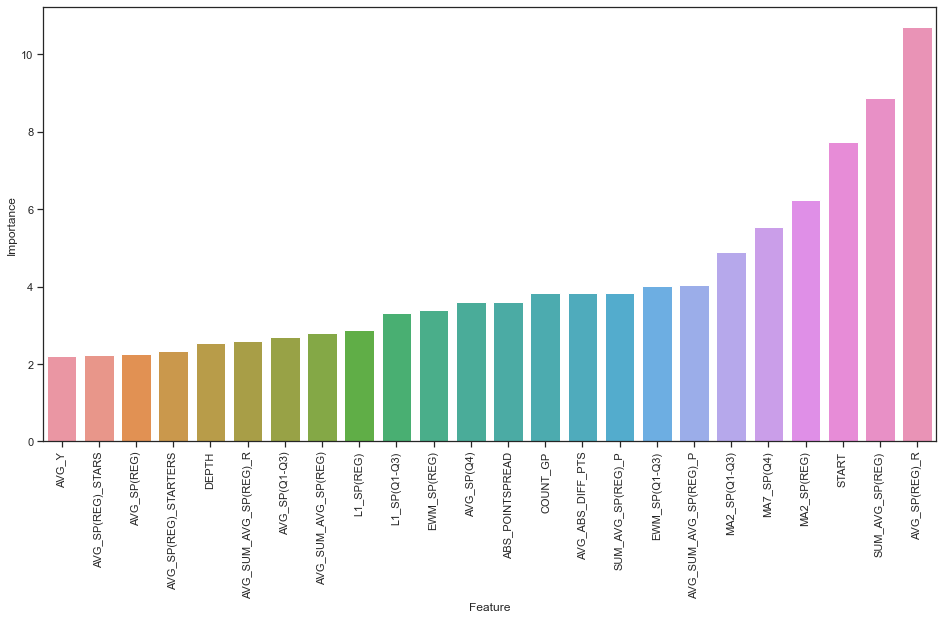

In [55]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

I will calculate a few metrics to evaluate the model's predictive power.

In [56]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_Y']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat, sample_weight=w_test), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg, sample_weight=w_test), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat, sample_weight=w_test), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg, sample_weight=w_test), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat, sample_weight=w_test)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg, sample_weight=w_test)), 6))

R2 (explained variance):
Model: 0.771
Baseline: 0.648

Mean Absolute Error (Σ|y-pred|/n):
Model: 271.870182
Baseline: 332.305331

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 354.381391
Baseline: 439.292075


Residual analysis:

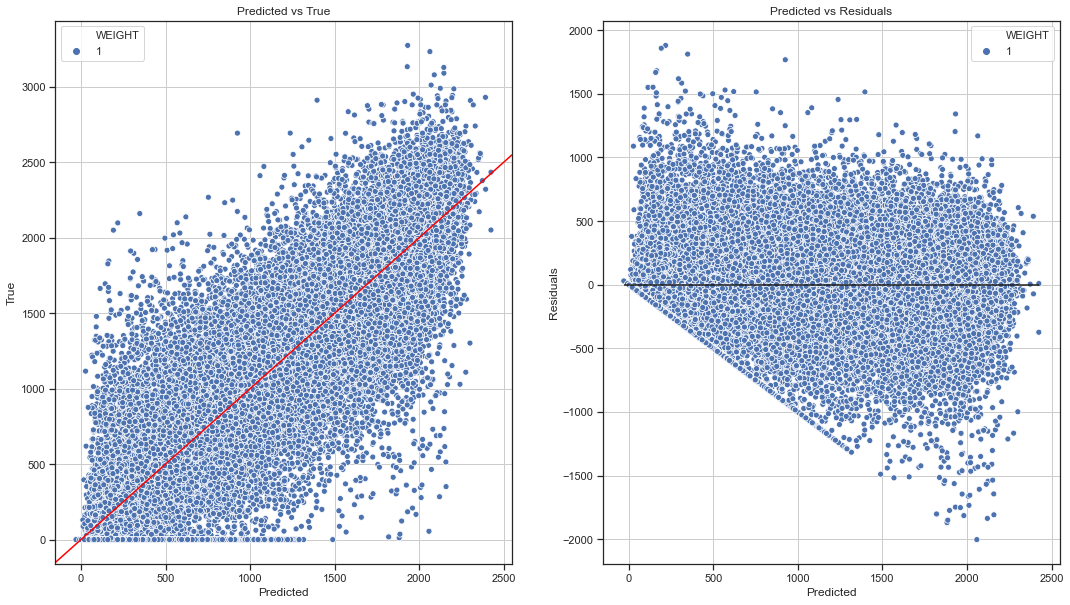

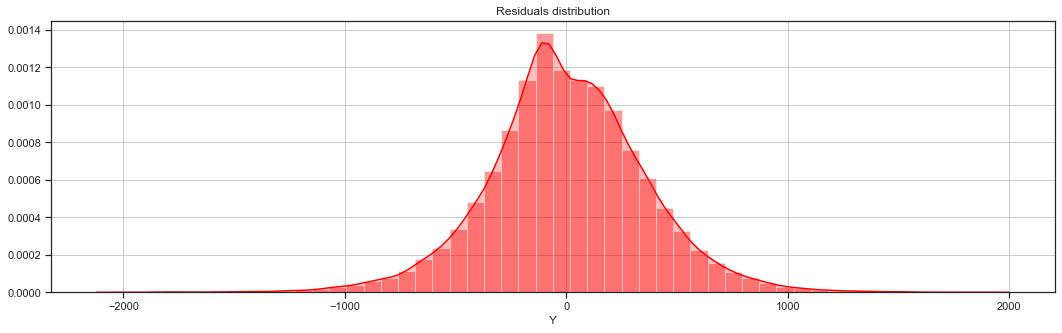

In [57]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, hue=w_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, hue=w_test, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [58]:
stat, p = shapiro(residuals)
print(stat, p)

0.9917327165603638 3.016995593691331e-42


Residuals are normally distributed and not heteroskedastic.

# Investigation

Let's look at specific situations in which we know injuries should be a factor.

Josh Hart got an uptick in minutes when LeBron James got injured in the 2018-19 season.

In [59]:
feature_matrix['Y_HAT'] = model.predict(feature_matrix[selected_features])

,DATE,NAME,START,Y_HAT,Y,AVG_Y,ABS_POINTSPREAD,STARS
118471,2018-10-20,Josh Hart,0,1517.992960,1821,1648.000000,3.5,2544
118788,2018-10-22,Josh Hart,0,1867.127834,2319,1734.500000,0.0,2544
119079,2018-10-24,Josh Hart,1,1851.065259,1582,1929.333333,2.5,2544
119222,2018-10-25,Josh Hart,1,1782.930605,1915,1842.500000,4.0,2544
119613,2018-10-27,Josh Hart,1,1739.482472,2176,1857.000000,1.5,2544
119891,2018-10-29,Josh Hart,0,1568.623931,1468,1910.166667,1.0,2544
120275,2018-10-31,Josh Hart,0,1495.359011,970,1847.000000,6.5,2544
120862,2018-11-03,Josh Hart,0,1359.564543,1518,1737.375000,3.5,2544
121035,2018-11-04,Josh Hart,0,1384.282400,1793,1713.000000,1.0,2544
121583,2018-11-07,Josh Hart,0,1516.614714,1287,1721.000000,5.0,2544


,DATE,NAME,START,Y_HAT,Y,AVG_Y,ABS_POINTSPREAD,STARS
131620,2019-01-04,Josh Hart,1,1989.921471,1991,1595.157895,8.5,


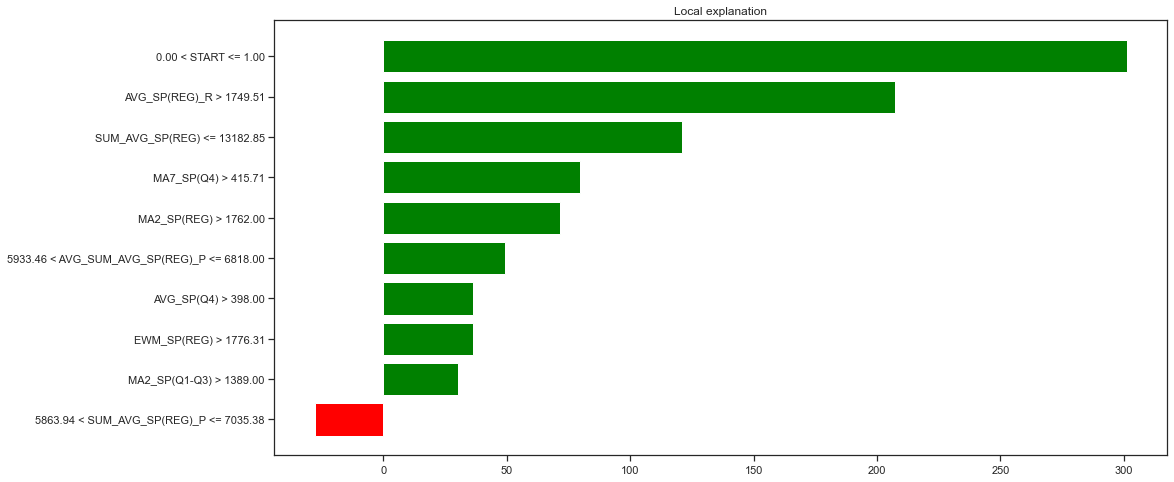

In [65]:
temp = feature_matrix.merge(
    boxscores[['GAMEID', 'PLAYERID', 'DATE', 'NAME', 'SEASON', 'STARS']],
    on=['GAMEID', 'PLAYERID'], how='left'
)

temp = temp.loc[(temp['NAME'] == 'Josh Hart') & (temp['SEASON'] == '2018-19')]
idx = temp.index[-29]

pd.set_option('display.min_rows', 82)
display(temp[['DATE', 'NAME', 'START', 'Y_HAT', 'Y', 'AVG_Y', 'ABS_POINTSPREAD', 'STARS']])
print()
display(temp.loc[[idx]][['DATE', 'NAME', 'START', 'Y_HAT', 'Y', 'AVG_Y', 'ABS_POINTSPREAD', 'STARS']])

explainer = lime_tabular.LimeTabularExplainer(training_data=feature_matrix[selected_features].values, feature_names=selected_features, class_names='Y', mode="regression")

explained = explainer.explain_instance(temp.loc[idx, selected_features].values, model.predict, num_features=10)
explained.as_pyplot_figure()
plt.show()
plt.close()

In [61]:
lbj_out = temp.loc[~temp['STARS'].str.contains('2544')]
lbj_in = temp.loc[temp['STARS'].str.contains('2544')]

print("\nAVG Y_HAT When LBJ Out:", round( lbj_out['Y_HAT'].mean() , 8))
print("AVG Y When LBJ Out:", round( lbj_out['Y'].mean() , 8))

print("\nAVG Y_HAT When LBJ In:", round( lbj_in['Y_HAT'].mean() , 8))
print("AVG Y When LBJ In:", round( lbj_in['Y'].mean() , 8))


AVG Y_HAT When LBJ Out: 1732.30537218
AVG Y When LBJ Out: 1731.84210526

AVG Y_HAT When LBJ In: 1486.77637197
AVG Y When LBJ In: 1454.0


The model seems to appropriately adjust for the injury.